### remember to change model saving path!!!

In [16]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss, TverskyLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT
from hybrid_model_v3 import HybridSegModel

In [17]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [18]:
import wandb
wandb.login()

True

In [19]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tx
import random
import cv2
from PIL import ImageEnhance
from skimage.exposure import match_histograms
import torchvision.transforms as T
import torchvision.transforms.functional as F
class Gland_Dataset(Dataset):
    def __init__(self, csv_file, transform, image_size):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.image_size = image_size
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df["image_name"][idx]
        mask_name = self.df["mask_name"][idx]

        from_folder = "../gland_data"
        
        image_path = f"{from_folder}/images/{image_name}"
        mask_path = f"{from_folder}/masks/{mask_name}"

        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        
        image_tensor, mask_tensor = self.transform(image, mask, self.image_size)
        mask_tensor = (mask_tensor > 0.5).float()
        if torch.sum(mask_tensor) == 0:
            # print("nothing")
            return [None]
        return image_tensor, mask_tensor

In [20]:
image_size = 128
batch_size = 128
def train_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    p = 0.7
    
    if(random.random() < p):
        jitter = T.ColorJitter(brightness = 0.5, contrast = 0.25)
        image = jitter(image)
    # if(random.random() < p):
    #     transform = T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
    #     image = transform(image)  # image must be a PIL image
    if(random.random() < p):
        # angle = random.uniform(-10, 10)  # 旋轉角度從 ±10 度
        angle = 0.0
        max_dx = 0.05  # 水平平移比例
        max_dy = 0.3  # 垂直平移比例
        translate_x = random.uniform(-max_dx, max_dx) * image.size[0]
        translate_y = random.uniform(-max_dy, max_dy) * image.size[1]
        translate = (int(translate_x), int(translate_y))
        scale = random.uniform(0.9, 1.6)  # 尺度縮放 ±5%
        # scale = 1.0
        # shear = [random.uniform(-5, 5), random.uniform(-5, 5)]  # 小幅剪切
        shear=[0.0, 0.0]
        image = F.affine(image, angle=angle, translate=translate, scale=scale, shear=shear)
        mask = F.affine(mask, angle=angle, translate=translate, scale=scale, shear=shear)

        
    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def test_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def custom_collate_fn(batch):
    # print(batch)
    filtered_batch = [item for item in batch if item[0] is not None]
    if len(filtered_batch) == 0:
        return [None, None]
    return torch.utils.data.dataloader.default_collate(filtered_batch)
train_dataset = Gland_Dataset("../gland_data/crop_benq_train.csv", transform = train_augmentation, image_size = image_size)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn=custom_collate_fn)

test_dataset = Gland_Dataset("../gland_data/crop_benq_test.csv", transform = test_augmentation, image_size = image_size)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, collate_fn=custom_collate_fn)

image, mask = next(iter(test_dataloader))

In [21]:
image.shape

torch.Size([59, 1, 128, 128])

In [22]:
print(len(train_dataset), len(test_dataset))

154 79


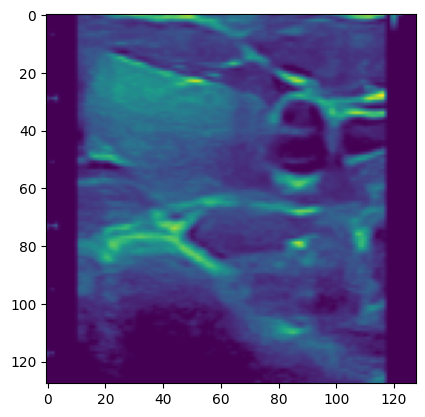

In [23]:
plt.imshow(image[18][0])

In [24]:
def train(dataloader, model, optimizer, loss_fn, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0
    
    model.train()
    model.to(device)
    count = 0
    for image, mask in tqdm(dataloader):
        if image == None:
            continue
        image, mask = image.to(device), mask.to(device)
        
        outputs = model(image)
        
        output = outputs[:, 1:2, :, :]
        
        
        loss = loss_fn(output, mask)

        IOU = IOU_score(output, mask)

        dice_loss = DiceLoss()
        DICE = 1 - dice_loss(output, mask)

        
        # Backward and optimize
        optimizer.zero_grad()   # clear previous gradients
        loss.backward()         # compute gradients
        optimizer.step()        # update weights

        total_loss += loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()
        count+=1
        # if count==5:
        #     break
    return total_loss/count, total_IOU/count, total_DICE/count


# 
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val(dataloader, model, loss_fn, device):
    total_loss = 0
    
    total_IOU = 0
    
    total_DICE = 0

    model.eval()
    model.to(device)
    conut = 0
    for image, mask in tqdm(dataloader):
        if image == None:
            continue
        image, mask = image.to(device), mask.to(device)
        outputs = model(image)
        
        output = outputs[:, 1:2, :, :]
        
        
        loss = loss_fn(output, mask)

        IOU = IOU_score(output, mask)

        dice_loss = DiceLoss()
        DICE = 1 - dice_loss(output, mask)
    

        total_loss += loss.item()
        
        total_IOU += IOU.item()
        
        total_DICE += DICE.item()
        conut += 1
    return total_loss/conut, total_IOU/conut, total_DICE/conut


    

In [25]:

inference_name = "models/Phase 1/Hybrid_crop_DDTI_standardization_aug_affine(0.5)_for_gland"

model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
checkpoint = torch.load(f"{inference_name}/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

<All keys matched successfully>

In [26]:
# freeze encoder
for param in model.backbone.parameters():
    param.requires_grad = False

In [27]:

epochs = 500
lr = 0.005
loss_fn = StructureLoss()
# loss_fn = TverskyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
# optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [28]:

project = "thyroid_gland_finetune"
name = "hybrid_model_gland_baseline(1)_freeze_encoder_wo_zeromask_aug_colorjitter_affine_crop"

wandb.init(
    project = project,  # Project name in W&B
    name = name,       # (optional) specific run name
    config={                     # (optional) hyperparameters
        "image_size": image_size,
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        # "weight_decay":1e-4
    }
)

In [29]:
print(f"image size : {image_size}, lr : {lr}, epochs : {epochs}, batch size : {batch_size}")

image size : 128, lr : 0.005, epochs : 500, batch size : 128


In [30]:
max_IOU = -1
for epoch in range(epochs):
    print(f"epoch : {epoch}")
    total_loss_train, total_IOU_train, total_DICE_train = train(train_dataloader, model, optimizer, loss_fn, "cuda")
    print(f"train loss : {total_loss_train}, train IOU : {total_IOU_train}, train DICE : {total_DICE_train}")
    total_loss_val, total_IOU_val, total_DICE_val = val(test_dataloader, model, loss_fn, "cuda")
    print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")
    
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]



    if max_IOU < total_IOU_val:
        max_IOU = total_IOU_val
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            "IOU" : total_IOU_val,
            "DICE" : total_DICE_val,
            "loss" : total_loss_val
        }
        folder = f"models/finetune/gland/{name}/"
        if not os.path.exists(folder):
            os.mkdir(folder)
        torch.save(checkpoint, f"models/finetune/gland/{name}/best_checkpoint.pth")

    
    wandb.log({
        "epoch": epoch,
        "Learning Rate":current_lr,
        
        "train_loss": total_loss_train,
        "train_IOU": total_IOU_train,
        "train_DICE": total_DICE_train,
        
        "val_loss": total_loss_val,
        "val_IOU": total_IOU_val,
        "val_DICE": total_DICE_val,
        
    })




checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    "IOU" : total_IOU_val,
    "DICE" : total_DICE_val,
    "loss" : total_loss_val
}
torch.save(checkpoint, f"models/finetune/gland/{name}/last_checkpoint.pth")
wandb.finish()

epoch : 0


/home/twszbak764/miniconda3/envs/thyroid/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 1.6591681838035583, train IOU : 0.38581183552742004, train DICE : 0.5308519601821899


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.9684093594551086, val IOU : 0.4998319745063782, val DICE : 0.661232590675354
epoch : 1


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 1.0202724933624268, train IOU : 0.5484525561332703, train DICE : 0.689193606376648


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.7842713594436646, val IOU : 0.5778983235359192, val DICE : 0.7262890338897705
epoch : 2


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.7993544042110443, train IOU : 0.642347514629364, train DICE : 0.7633283138275146


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.7105095386505127, val IOU : 0.6079257130622864, val DICE : 0.7490456700325012
epoch : 3


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.7074525952339172, train IOU : 0.6761444807052612, train DICE : 0.7897098362445831


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


val loss : 0.6861279010772705, val IOU : 0.6184247732162476, val DICE : 0.7542890906333923
epoch : 4


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.7459444999694824, train IOU : 0.6611810326576233, train DICE : 0.777638852596283


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.667914628982544, val IOU : 0.6251327991485596, val DICE : 0.7570855021476746
epoch : 5


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.7062382400035858, train IOU : 0.6869871318340302, train DICE : 0.7944838106632233


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.6505389213562012, val IOU : 0.6283891201019287, val DICE : 0.7593837380409241
epoch : 6


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.7109188139438629, train IOU : 0.6750764548778534, train DICE : 0.7859432995319366


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.6317124366760254, val IOU : 0.6316897869110107, val DICE : 0.7616844177246094
epoch : 7


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.6386107206344604, train IOU : 0.6931381523609161, train DICE : 0.7975336313247681


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.62436443567276, val IOU : 0.6321344375610352, val DICE : 0.7603927254676819
epoch : 8


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.6187048256397247, train IOU : 0.6796658933162689, train DICE : 0.783740758895874


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.6279371976852417, val IOU : 0.6277709007263184, val DICE : 0.7552706003189087
epoch : 9


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.5729366540908813, train IOU : 0.695734441280365, train DICE : 0.7988077700138092


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.6426400542259216, val IOU : 0.6177825927734375, val DICE : 0.7452993392944336
epoch : 10


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.5983168482780457, train IOU : 0.7061101198196411, train DICE : 0.7988452911376953


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.6499917507171631, val IOU : 0.6104708313941956, val DICE : 0.7386555075645447
epoch : 11


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.5623876750469208, train IOU : 0.7152978479862213, train DICE : 0.8015071153640747


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.636150062084198, val IOU : 0.6160250902175903, val DICE : 0.7400466799736023
epoch : 12


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.5260663032531738, train IOU : 0.7231127917766571, train DICE : 0.8160772621631622


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.6088194251060486, val IOU : 0.6256729364395142, val DICE : 0.7448400855064392
epoch : 13


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.5163809657096863, train IOU : 0.7354108691215515, train DICE : 0.8162496089935303


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.5854902863502502, val IOU : 0.6339141726493835, val DICE : 0.7486920952796936
epoch : 14


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.5189588367938995, train IOU : 0.7225185036659241, train DICE : 0.8123746514320374


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


val loss : 0.5678313374519348, val IOU : 0.6396149396896362, val DICE : 0.750326931476593
epoch : 15


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.4733259379863739, train IOU : 0.729063481092453, train DICE : 0.8122414350509644


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.5543114542961121, val IOU : 0.6433263421058655, val DICE : 0.7501182556152344
epoch : 16


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.4672215133905411, train IOU : 0.753673642873764, train DICE : 0.8267939686775208


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.5503222346305847, val IOU : 0.6424336433410645, val DICE : 0.7471756339073181
epoch : 17


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.4652930051088333, train IOU : 0.7444866001605988, train DICE : 0.8262015581130981


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.5444760322570801, val IOU : 0.6457202434539795, val DICE : 0.7472789883613586
epoch : 18


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.4746561497449875, train IOU : 0.7457205057144165, train DICE : 0.8212153315544128


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.5434198379516602, val IOU : 0.6458739638328552, val DICE : 0.7466743588447571
epoch : 19


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.4445209205150604, train IOU : 0.7630333304405212, train DICE : 0.8343882858753204


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.5418708324432373, val IOU : 0.6480804085731506, val DICE : 0.7477322220802307
epoch : 20


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


train loss : 0.4478740245103836, train IOU : 0.7489081919193268, train DICE : 0.8244657516479492


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.5376989841461182, val IOU : 0.6529266834259033, val DICE : 0.7494142651557922
epoch : 21


100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


train loss : 0.4556805193424225, train IOU : 0.7520821988582611, train DICE : 0.8205600380897522


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.5349323749542236, val IOU : 0.6566371321678162, val DICE : 0.7496124505996704
epoch : 22


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.4568866938352585, train IOU : 0.7570671439170837, train DICE : 0.8219459056854248


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.5303301811218262, val IOU : 0.6585639715194702, val DICE : 0.7490755319595337
epoch : 23


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.40740540623664856, train IOU : 0.7762114405632019, train DICE : 0.8369872272014618


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


val loss : 0.5284433960914612, val IOU : 0.6587389707565308, val DICE : 0.7478500008583069
epoch : 24


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.44203126430511475, train IOU : 0.776679128408432, train DICE : 0.8340883255004883


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.5200430750846863, val IOU : 0.6636422276496887, val DICE : 0.7499687075614929
epoch : 25


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.40423788130283356, train IOU : 0.7863472998142242, train DICE : 0.84467613697052


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.5161983966827393, val IOU : 0.6633316278457642, val DICE : 0.7489311099052429
epoch : 26


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.4230533540248871, train IOU : 0.77237269282341, train DICE : 0.8339839577674866


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.514718770980835, val IOU : 0.6630790829658508, val DICE : 0.7477472424507141
epoch : 27


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.43061406910419464, train IOU : 0.776015043258667, train DICE : 0.8401234447956085


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.511540412902832, val IOU : 0.6654288172721863, val DICE : 0.7491456270217896
epoch : 28


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.42052915692329407, train IOU : 0.7789759635925293, train DICE : 0.842456728219986


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.5055944323539734, val IOU : 0.6703426837921143, val DICE : 0.7530572414398193
epoch : 29


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.44380564987659454, train IOU : 0.7756699621677399, train DICE : 0.8385728597640991


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


val loss : 0.5002582669258118, val IOU : 0.6740419864654541, val DICE : 0.7561147809028625
epoch : 30


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.41713234782218933, train IOU : 0.7774143815040588, train DICE : 0.8367716372013092


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.49840492010116577, val IOU : 0.6764835715293884, val DICE : 0.7581265568733215
epoch : 31


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.40771959722042084, train IOU : 0.7797280848026276, train DICE : 0.841400146484375


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.49517083168029785, val IOU : 0.6796638369560242, val DICE : 0.7600391507148743
epoch : 32


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.4011107236146927, train IOU : 0.7911616563796997, train DICE : 0.8476991355419159


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.49000492691993713, val IOU : 0.6835886836051941, val DICE : 0.7627899050712585
epoch : 33


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.38868942856788635, train IOU : 0.7858910262584686, train DICE : 0.8433600962162018


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4866860806941986, val IOU : 0.6853653192520142, val DICE : 0.7632158994674683
epoch : 34


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


train loss : 0.38904204964637756, train IOU : 0.7977302372455597, train DICE : 0.8511585295200348


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.48301374912261963, val IOU : 0.6881876587867737, val DICE : 0.7641922831535339
epoch : 35


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.3999829590320587, train IOU : 0.7817474603652954, train DICE : 0.8399889469146729


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4789868891239166, val IOU : 0.6912636160850525, val DICE : 0.7660815715789795
epoch : 36


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.39730818569660187, train IOU : 0.781088262796402, train DICE : 0.8433325886726379


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


val loss : 0.4770001769065857, val IOU : 0.6926078796386719, val DICE : 0.7664534449577332
epoch : 37


100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


train loss : 0.3815345913171768, train IOU : 0.8005442917346954, train DICE : 0.8565232455730438


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.4784867465496063, val IOU : 0.6909906268119812, val DICE : 0.7647493481636047
epoch : 38


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.37937241792678833, train IOU : 0.803919643163681, train DICE : 0.8565149307250977


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.48259690403938293, val IOU : 0.6873761415481567, val DICE : 0.7622910737991333
epoch : 39


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.3778786063194275, train IOU : 0.8104892671108246, train DICE : 0.8605137169361115


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.48290687799453735, val IOU : 0.6868674159049988, val DICE : 0.7639512419700623
epoch : 40


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.35586658120155334, train IOU : 0.8183054327964783, train DICE : 0.8687551617622375


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4840584993362427, val IOU : 0.6853356957435608, val DICE : 0.7656909823417664
epoch : 41


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.36515772342681885, train IOU : 0.8058646023273468, train DICE : 0.8626150190830231


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4847981035709381, val IOU : 0.685784637928009, val DICE : 0.7681209444999695
epoch : 42


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.3605644404888153, train IOU : 0.8002015352249146, train DICE : 0.8628409802913666


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4828147888183594, val IOU : 0.68722003698349, val DICE : 0.7699118852615356
epoch : 43


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.39580586552619934, train IOU : 0.7854013442993164, train DICE : 0.851628452539444


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.47621381282806396, val IOU : 0.6924225091934204, val DICE : 0.7725294232368469
epoch : 44


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.361588254570961, train IOU : 0.7949747741222382, train DICE : 0.8570441901683807


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.47585365176200867, val IOU : 0.6928136944770813, val DICE : 0.7703760862350464
epoch : 45


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.32578182220458984, train IOU : 0.8287574648857117, train DICE : 0.8738270401954651


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


val loss : 0.47536107897758484, val IOU : 0.6938371062278748, val DICE : 0.7707086801528931
epoch : 46


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.31688129901885986, train IOU : 0.8334720432758331, train DICE : 0.8813408315181732


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.46989959478378296, val IOU : 0.7001320719718933, val DICE : 0.7768630385398865
epoch : 47


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.3441755771636963, train IOU : 0.8208101093769073, train DICE : 0.8723395764827728


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.46672895550727844, val IOU : 0.7034263014793396, val DICE : 0.7825574278831482
epoch : 48


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.3741808831691742, train IOU : 0.8090882897377014, train DICE : 0.8689796626567841


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.4641367197036743, val IOU : 0.70604008436203, val DICE : 0.7862850427627563
epoch : 49


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.35000260174274445, train IOU : 0.826753556728363, train DICE : 0.8757622539997101


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4636567234992981, val IOU : 0.7045829892158508, val DICE : 0.7859497666358948
epoch : 50


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.3389216214418411, train IOU : 0.808568924665451, train DICE : 0.8677037060260773


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.46320202946662903, val IOU : 0.7013214230537415, val DICE : 0.7833392024040222
epoch : 51


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.3503401577472687, train IOU : 0.7993919849395752, train DICE : 0.8588694036006927


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.46036046743392944, val IOU : 0.7020331025123596, val DICE : 0.7824798822402954
epoch : 52


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.3502901941537857, train IOU : 0.8121632039546967, train DICE : 0.8633175790309906


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.45517662167549133, val IOU : 0.7082163691520691, val DICE : 0.7864676117897034
epoch : 53


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.32906360924243927, train IOU : 0.8330029547214508, train DICE : 0.8790871500968933


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.45114970207214355, val IOU : 0.7134832739830017, val DICE : 0.7911021113395691
epoch : 54


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.3378671705722809, train IOU : 0.8216401934623718, train DICE : 0.8788191080093384


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.44889897108078003, val IOU : 0.7154101133346558, val DICE : 0.7929404377937317
epoch : 55


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.32957376539707184, train IOU : 0.8361350893974304, train DICE : 0.8850437998771667


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4482613205909729, val IOU : 0.7136116623878479, val DICE : 0.7918291687965393
epoch : 56


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.3258165121078491, train IOU : 0.8246864378452301, train DICE : 0.8769924938678741


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4502304196357727, val IOU : 0.7093062400817871, val DICE : 0.7888351082801819
epoch : 57


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.32352688908576965, train IOU : 0.830683022737503, train DICE : 0.8795314431190491


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4508824348449707, val IOU : 0.7095768451690674, val DICE : 0.7893778681755066
epoch : 58


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.3253370225429535, train IOU : 0.8332140445709229, train DICE : 0.8811517953872681


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.45230984687805176, val IOU : 0.7122066020965576, val DICE : 0.7925893068313599
epoch : 59


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.3206995725631714, train IOU : 0.8240993618965149, train DICE : 0.8802708983421326


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.45766016840934753, val IOU : 0.7116830945014954, val DICE : 0.7920193076133728
epoch : 60


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.3159930557012558, train IOU : 0.8408274948596954, train DICE : 0.8877009153366089


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.460578978061676, val IOU : 0.709865391254425, val DICE : 0.7906947135925293
epoch : 61


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.3422239124774933, train IOU : 0.8229215145111084, train DICE : 0.8725568652153015


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.45526233315467834, val IOU : 0.7116750478744507, val DICE : 0.7929913401603699
epoch : 62


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.3241903632879257, train IOU : 0.8226606845855713, train DICE : 0.8748505115509033


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.4481360912322998, val IOU : 0.7148871421813965, val DICE : 0.79655921459198
epoch : 63


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.3107639104127884, train IOU : 0.8353709578514099, train DICE : 0.8872495889663696


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4433319568634033, val IOU : 0.7172919511795044, val DICE : 0.7980573177337646
epoch : 64


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.33094920217990875, train IOU : 0.8183206915855408, train DICE : 0.87510946393013


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.4415600597858429, val IOU : 0.718914806842804, val DICE : 0.7997365593910217
epoch : 65


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.30707114934921265, train IOU : 0.83854079246521, train DICE : 0.8895638883113861


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.438181608915329, val IOU : 0.7243372797966003, val DICE : 0.804121196269989
epoch : 66


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.3066403418779373, train IOU : 0.8369665145874023, train DICE : 0.8887293636798859


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.43363726139068604, val IOU : 0.7278086543083191, val DICE : 0.806309700012207
epoch : 67


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.31775544583797455, train IOU : 0.8266189098358154, train DICE : 0.8837508857250214


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4329884946346283, val IOU : 0.7258020043373108, val DICE : 0.805504560470581
epoch : 68


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.3069005459547043, train IOU : 0.8438927531242371, train DICE : 0.8906289041042328


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4334189295768738, val IOU : 0.7234731316566467, val DICE : 0.8038807511329651
epoch : 69


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.3234861344099045, train IOU : 0.8367756903171539, train DICE : 0.8818083703517914


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4358462393283844, val IOU : 0.7221437692642212, val DICE : 0.8037316799163818
epoch : 70


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.3137923628091812, train IOU : 0.8308561444282532, train DICE : 0.8884938359260559


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.43741557002067566, val IOU : 0.7240565419197083, val DICE : 0.8048827648162842
epoch : 71


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.304229736328125, train IOU : 0.8315763771533966, train DICE : 0.8876015245914459


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.44045430421829224, val IOU : 0.7217941880226135, val DICE : 0.8021136522293091
epoch : 72


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.3123696446418762, train IOU : 0.8380340039730072, train DICE : 0.8893632888793945


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4435518980026245, val IOU : 0.718170166015625, val DICE : 0.7984694242477417
epoch : 73


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.3494661748409271, train IOU : 0.8240374326705933, train DICE : 0.8775959014892578


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.43724364042282104, val IOU : 0.7227305769920349, val DICE : 0.8029285073280334
epoch : 74


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.3030575215816498, train IOU : 0.8451298773288727, train DICE : 0.890742689371109


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4306376874446869, val IOU : 0.7299936413764954, val DICE : 0.8095863461494446
epoch : 75


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.3176407963037491, train IOU : 0.8299646377563477, train DICE : 0.8860301971435547


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


val loss : 0.43413177132606506, val IOU : 0.729546070098877, val DICE : 0.8088943958282471
epoch : 76


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.29648083448410034, train IOU : 0.8492452502250671, train DICE : 0.8987467885017395


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.43983861804008484, val IOU : 0.7236674427986145, val DICE : 0.8042017221450806
epoch : 77


100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


train loss : 0.2903844118118286, train IOU : 0.8504675030708313, train DICE : 0.8987171947956085


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.44724196195602417, val IOU : 0.7134091854095459, val DICE : 0.7965145707130432
epoch : 78


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.29834817349910736, train IOU : 0.8460361659526825, train DICE : 0.8954810798168182


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4504376947879791, val IOU : 0.7085980176925659, val DICE : 0.792996346950531
epoch : 79


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.2704068571329117, train IOU : 0.8633126318454742, train DICE : 0.9048662781715393


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


val loss : 0.45172443985939026, val IOU : 0.707066535949707, val DICE : 0.7920414209365845
epoch : 80


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.30935464799404144, train IOU : 0.8385249972343445, train DICE : 0.89231738448143


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.44563576579093933, val IOU : 0.7108953595161438, val DICE : 0.795981764793396
epoch : 81


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.29925957322120667, train IOU : 0.8421694934368134, train DICE : 0.8938695788383484


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.43575242161750793, val IOU : 0.7178135514259338, val DICE : 0.8010743856430054
epoch : 82


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2919142544269562, train IOU : 0.8404030203819275, train DICE : 0.8911160230636597


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4245682954788208, val IOU : 0.7299160957336426, val DICE : 0.8104095458984375
epoch : 83


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.2962750792503357, train IOU : 0.8483003079891205, train DICE : 0.8937153220176697


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.426614373922348, val IOU : 0.7372881174087524, val DICE : 0.8172142505645752
epoch : 84


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.3118794858455658, train IOU : 0.8400342464447021, train DICE : 0.8898292779922485


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4337395429611206, val IOU : 0.738679826259613, val DICE : 0.818867027759552
epoch : 85


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.3009994477033615, train IOU : 0.8428993225097656, train DICE : 0.8945432901382446


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.42970457673072815, val IOU : 0.738736629486084, val DICE : 0.8188348412513733
epoch : 86


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.2798103094100952, train IOU : 0.8564547002315521, train DICE : 0.9031517505645752


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.42719191312789917, val IOU : 0.7296727895736694, val DICE : 0.8122721314430237
epoch : 87


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.3127545565366745, train IOU : 0.8375504314899445, train DICE : 0.8900108337402344


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.432653546333313, val IOU : 0.7196970582008362, val DICE : 0.8027323484420776
epoch : 88


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.28339533507823944, train IOU : 0.859050452709198, train DICE : 0.9027015864849091


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.437914103269577, val IOU : 0.7179493308067322, val DICE : 0.8005096316337585
epoch : 89


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.3020119220018387, train IOU : 0.8453468382358551, train DICE : 0.8971926867961884


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4366345703601837, val IOU : 0.7219147682189941, val DICE : 0.8046743273735046
epoch : 90


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.28282296657562256, train IOU : 0.8553245961666107, train DICE : 0.9044108390808105


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.4324488341808319, val IOU : 0.7258210182189941, val DICE : 0.8081158399581909
epoch : 91


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.2801269441843033, train IOU : 0.8571882843971252, train DICE : 0.9024069905281067


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.4317191243171692, val IOU : 0.7257197499275208, val DICE : 0.8074712753295898
epoch : 92


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.28698500990867615, train IOU : 0.8414078950881958, train DICE : 0.8912280797958374


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.44580161571502686, val IOU : 0.7155663967132568, val DICE : 0.7989563941955566
epoch : 93


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.2985851317644119, train IOU : 0.8504444360733032, train DICE : 0.8924593925476074


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4417632222175598, val IOU : 0.7205848097801208, val DICE : 0.802534818649292
epoch : 94


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.28641173243522644, train IOU : 0.8452390432357788, train DICE : 0.8924010694026947


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4307490885257721, val IOU : 0.7314785718917847, val DICE : 0.8110657930374146
epoch : 95


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.27668771147727966, train IOU : 0.8631287813186646, train DICE : 0.9053277969360352


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.427973210811615, val IOU : 0.7348139882087708, val DICE : 0.8145224452018738
epoch : 96


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.3328819274902344, train IOU : 0.8196015655994415, train DICE : 0.8784632682800293


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.424489289522171, val IOU : 0.7356593012809753, val DICE : 0.8141621351242065
epoch : 97


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.29384957253932953, train IOU : 0.8558284342288971, train DICE : 0.8988112211227417


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.42438703775405884, val IOU : 0.7342618107795715, val DICE : 0.8117625713348389
epoch : 98


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2761547416448593, train IOU : 0.855158805847168, train DICE : 0.897984653711319


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.42326679825782776, val IOU : 0.7333085536956787, val DICE : 0.8119958639144897
epoch : 99


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.29069972038269043, train IOU : 0.8456039130687714, train DICE : 0.897424191236496


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.42452141642570496, val IOU : 0.7331361770629883, val DICE : 0.8127368092536926
epoch : 100


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.2675348222255707, train IOU : 0.8649775981903076, train DICE : 0.9077093303203583


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4237619936466217, val IOU : 0.7340035438537598, val DICE : 0.8141207098960876
epoch : 101


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.27505379915237427, train IOU : 0.8590892255306244, train DICE : 0.9036265015602112


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.42170456051826477, val IOU : 0.7340871095657349, val DICE : 0.8149663209915161
epoch : 102


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.2882270812988281, train IOU : 0.8505461812019348, train DICE : 0.9015498459339142


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.42198970913887024, val IOU : 0.7306690812110901, val DICE : 0.8128663301467896
epoch : 103


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.3011319190263748, train IOU : 0.8523899912834167, train DICE : 0.8974014818668365


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.42260441184043884, val IOU : 0.7299833297729492, val DICE : 0.8130203485488892
epoch : 104


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.2807227075099945, train IOU : 0.8507059812545776, train DICE : 0.9027065336704254


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.42182475328445435, val IOU : 0.7320578694343567, val DICE : 0.8150774240493774
epoch : 105


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.28398534655570984, train IOU : 0.8466145992279053, train DICE : 0.8950298726558685


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.42445820569992065, val IOU : 0.7302563190460205, val DICE : 0.8133612871170044
epoch : 106


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.2552397921681404, train IOU : 0.8672721087932587, train DICE : 0.908934623003006


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.43051397800445557, val IOU : 0.7287266254425049, val DICE : 0.8103746175765991
epoch : 107


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.299266055226326, train IOU : 0.8506889641284943, train DICE : 0.8932505548000336


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.42709553241729736, val IOU : 0.7326735258102417, val DICE : 0.8127237558364868
epoch : 108


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.27496349811553955, train IOU : 0.8612480461597443, train DICE : 0.9025963842868805


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.42042961716651917, val IOU : 0.7359673380851746, val DICE : 0.815914511680603
epoch : 109


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.26286517083644867, train IOU : 0.8617989122867584, train DICE : 0.9076148867607117


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


val loss : 0.4161119759082794, val IOU : 0.73777174949646, val DICE : 0.818398118019104
epoch : 110


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.2772129774093628, train IOU : 0.8542768061161041, train DICE : 0.9030029475688934


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4196303188800812, val IOU : 0.7331576347351074, val DICE : 0.815401554107666
epoch : 111


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.2807021141052246, train IOU : 0.8517676591873169, train DICE : 0.8948622345924377


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.42541250586509705, val IOU : 0.7275451421737671, val DICE : 0.8106744885444641
epoch : 112


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.2809674143791199, train IOU : 0.8614046275615692, train DICE : 0.905385434627533


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.428443968296051, val IOU : 0.7275271415710449, val DICE : 0.8103620409965515
epoch : 113


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.2561018764972687, train IOU : 0.8717014789581299, train DICE : 0.9118299782276154


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.4308260977268219, val IOU : 0.7285473942756653, val DICE : 0.8118318915367126
epoch : 114


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2836357653141022, train IOU : 0.8616682887077332, train DICE : 0.9044841229915619


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.42780813574790955, val IOU : 0.7323578596115112, val DICE : 0.8162646889686584
epoch : 115


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2696582227945328, train IOU : 0.8571951687335968, train DICE : 0.9026190340518951


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4232615530490875, val IOU : 0.7337445020675659, val DICE : 0.818256139755249
epoch : 116


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.2880484610795975, train IOU : 0.8551835715770721, train DICE : 0.901932418346405


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4292754530906677, val IOU : 0.7287681698799133, val DICE : 0.8128671050071716
epoch : 117


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.25148867070674896, train IOU : 0.8735519647598267, train DICE : 0.9101855754852295


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.43911102414131165, val IOU : 0.7216892838478088, val DICE : 0.8068612217903137
epoch : 118


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.28442850708961487, train IOU : 0.8533383905887604, train DICE : 0.9000642001628876


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4309959411621094, val IOU : 0.7268891334533691, val DICE : 0.8111634850502014
epoch : 119


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.2694614678621292, train IOU : 0.8677657544612885, train DICE : 0.909968376159668


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4253053367137909, val IOU : 0.7279829978942871, val DICE : 0.8135776519775391
epoch : 120


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.2655075490474701, train IOU : 0.8648422658443451, train DICE : 0.9065125286579132


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4230669438838959, val IOU : 0.729324460029602, val DICE : 0.815182089805603
epoch : 121


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2730640023946762, train IOU : 0.8494299054145813, train DICE : 0.9002007842063904


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.42258402705192566, val IOU : 0.7298131585121155, val DICE : 0.8143981099128723
epoch : 122


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.2558073103427887, train IOU : 0.871203601360321, train DICE : 0.9094847142696381


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4298272728919983, val IOU : 0.7279151678085327, val DICE : 0.8111289143562317
epoch : 123


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.2619379013776779, train IOU : 0.8712417483329773, train DICE : 0.9113314151763916


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4309573471546173, val IOU : 0.7337686419487, val DICE : 0.8156538009643555
epoch : 124


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.2516019567847252, train IOU : 0.8786779940128326, train DICE : 0.9135600924491882


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4269448518753052, val IOU : 0.7397703528404236, val DICE : 0.8217290043830872
epoch : 125


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.290706530213356, train IOU : 0.8478567898273468, train DICE : 0.8978627026081085


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


val loss : 0.42103880643844604, val IOU : 0.737951397895813, val DICE : 0.8213150501251221
epoch : 126


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.26356448233127594, train IOU : 0.8670942783355713, train DICE : 0.9112831354141235


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


val loss : 0.41695889830589294, val IOU : 0.7319730520248413, val DICE : 0.8149850368499756
epoch : 127


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.26737523078918457, train IOU : 0.8580941557884216, train DICE : 0.9035435020923615


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.42605093121528625, val IOU : 0.7222365736961365, val DICE : 0.8057101368904114
epoch : 128


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.26677267253398895, train IOU : 0.8662865459918976, train DICE : 0.9060615003108978


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.42248812317848206, val IOU : 0.7301667332649231, val DICE : 0.8110135197639465
epoch : 129


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.25081775337457657, train IOU : 0.874969094991684, train DICE : 0.9140685200691223


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.4273403584957123, val IOU : 0.7349516749382019, val DICE : 0.8160632848739624
epoch : 130


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.265598401427269, train IOU : 0.8623404800891876, train DICE : 0.9077589511871338


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


val loss : 0.43061092495918274, val IOU : 0.7345377802848816, val DICE : 0.8167291879653931
epoch : 131


100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


train loss : 0.26226890087127686, train IOU : 0.8721430003643036, train DICE : 0.9131806790828705


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.43113836646080017, val IOU : 0.7286339402198792, val DICE : 0.8141875267028809
epoch : 132


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.25298264622688293, train IOU : 0.8748416006565094, train DICE : 0.9142968356609344


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


val loss : 0.43262147903442383, val IOU : 0.7232261896133423, val DICE : 0.8094552755355835
epoch : 133


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.2740533649921417, train IOU : 0.8644258379936218, train DICE : 0.9075576663017273


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


val loss : 0.42883285880088806, val IOU : 0.7248774170875549, val DICE : 0.8103529810905457
epoch : 134


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.26313187181949615, train IOU : 0.871919721364975, train DICE : 0.9106660485267639


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.42091667652130127, val IOU : 0.7337574362754822, val DICE : 0.8175894021987915
epoch : 135


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


train loss : 0.24300072342157364, train IOU : 0.8773698806762695, train DICE : 0.9166482985019684


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


val loss : 0.41774532198905945, val IOU : 0.7385674118995667, val DICE : 0.8213830590248108
epoch : 136


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.239541195333004, train IOU : 0.8773216307163239, train DICE : 0.9181594252586365


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


val loss : 0.41777241230010986, val IOU : 0.7385199666023254, val DICE : 0.8213068246841431
epoch : 137


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


train loss : 0.27067728340625763, train IOU : 0.8568442165851593, train DICE : 0.9050155282020569


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


val loss : 0.4209672212600708, val IOU : 0.7324916124343872, val DICE : 0.8172401785850525
epoch : 138


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.2744613140821457, train IOU : 0.8700166642665863, train DICE : 0.9131855666637421


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


val loss : 0.4244192838668823, val IOU : 0.7242227792739868, val DICE : 0.8106895685195923
epoch : 139


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


train loss : 0.2620829790830612, train IOU : 0.8729376196861267, train DICE : 0.912225067615509


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


val loss : 0.4272840917110443, val IOU : 0.7200995087623596, val DICE : 0.8084790706634521
epoch : 140


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


train loss : 0.2629929929971695, train IOU : 0.8633407950401306, train DICE : 0.9082272350788116


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


val loss : 0.42769506573677063, val IOU : 0.7218869924545288, val DICE : 0.8091313242912292
epoch : 141


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.25655466318130493, train IOU : 0.8703950047492981, train DICE : 0.9130213856697083


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


val loss : 0.42842891812324524, val IOU : 0.7230150699615479, val DICE : 0.8094398975372314
epoch : 142


100%|██████████| 2/2 [00:01<00:00,  1.38it/s]


train loss : 0.2731384336948395, train IOU : 0.8570526838302612, train DICE : 0.9035918116569519


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


val loss : 0.4305908977985382, val IOU : 0.7242638468742371, val DICE : 0.8097505569458008
epoch : 143


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


train loss : 0.260651096701622, train IOU : 0.8671421706676483, train DICE : 0.9083512723445892


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


val loss : 0.4300602972507477, val IOU : 0.7297887802124023, val DICE : 0.813102662563324
epoch : 144


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


train loss : 0.2528283819556236, train IOU : 0.8742454051971436, train DICE : 0.9131968915462494


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.4262103736400604, val IOU : 0.7376668453216553, val DICE : 0.8205845355987549
epoch : 145


100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


train loss : 0.25150779634714127, train IOU : 0.8628400564193726, train DICE : 0.9112477600574493


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


val loss : 0.42730024456977844, val IOU : 0.7386537194252014, val DICE : 0.8221666216850281
epoch : 146


100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


train loss : 0.260467067360878, train IOU : 0.8723261952400208, train DICE : 0.915587991476059


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


val loss : 0.42786943912506104, val IOU : 0.7377522587776184, val DICE : 0.8219069838523865
epoch : 147


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


train loss : 0.27624909579753876, train IOU : 0.8676518499851227, train DICE : 0.9109055399894714


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


val loss : 0.4218422770500183, val IOU : 0.7389975190162659, val DICE : 0.8231716752052307
epoch : 148


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


train loss : 0.2505519464612007, train IOU : 0.8719038367271423, train DICE : 0.9159723222255707


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


val loss : 0.4182417392730713, val IOU : 0.7346610426902771, val DICE : 0.8201241493225098
epoch : 149


100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


train loss : 0.2659226730465889, train IOU : 0.8687523901462555, train DICE : 0.9091635346412659


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


val loss : 0.41624683141708374, val IOU : 0.7343029975891113, val DICE : 0.8196526765823364
epoch : 150


100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


train loss : 0.24887258559465408, train IOU : 0.8749134242534637, train DICE : 0.9152860939502716


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


val loss : 0.4261094331741333, val IOU : 0.7323400378227234, val DICE : 0.8175941705703735
epoch : 151


100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


train loss : 0.25526684522628784, train IOU : 0.8662137985229492, train DICE : 0.9114368259906769


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


val loss : 0.4394102990627289, val IOU : 0.7291545271873474, val DICE : 0.8148776292800903
epoch : 152


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.27915869653224945, train IOU : 0.8498181700706482, train DICE : 0.9030012488365173


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


val loss : 0.4472670555114746, val IOU : 0.7227833867073059, val DICE : 0.8084957599639893
epoch : 153


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.2629239037632942, train IOU : 0.8697271645069122, train DICE : 0.9100861549377441


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


val loss : 0.43657273054122925, val IOU : 0.7260383367538452, val DICE : 0.8101230263710022
epoch : 154


100%|██████████| 2/2 [00:01<00:00,  1.38it/s]


train loss : 0.24019001424312592, train IOU : 0.8765583634376526, train DICE : 0.9155861139297485


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


val loss : 0.4186440408229828, val IOU : 0.739281952381134, val DICE : 0.821969747543335
epoch : 155


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.25629228353500366, train IOU : 0.8684701025485992, train DICE : 0.9125059247016907


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.41448599100112915, val IOU : 0.7416209578514099, val DICE : 0.8246491551399231
epoch : 156


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.28054478764533997, train IOU : 0.8531898260116577, train DICE : 0.9075087010860443


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4154895842075348, val IOU : 0.7381178140640259, val DICE : 0.8216249942779541
epoch : 157


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.23237967491149902, train IOU : 0.8790734708309174, train DICE : 0.9201881587505341


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.41853898763656616, val IOU : 0.7332247495651245, val DICE : 0.8175450563430786
epoch : 158


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.2562416195869446, train IOU : 0.8712878823280334, train DICE : 0.9161995947360992


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.4198928475379944, val IOU : 0.7327567338943481, val DICE : 0.8164121508598328
epoch : 159


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


train loss : 0.25352106243371964, train IOU : 0.8652118742465973, train DICE : 0.9098066687583923


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


val loss : 0.42045819759368896, val IOU : 0.7336503267288208, val DICE : 0.8163247108459473
epoch : 160


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


train loss : 0.24277344346046448, train IOU : 0.8811552822589874, train DICE : 0.9203609228134155


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.4186989665031433, val IOU : 0.7363408207893372, val DICE : 0.8188194632530212
epoch : 161


100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


train loss : 0.2537459135055542, train IOU : 0.863997608423233, train DICE : 0.9108257591724396


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


val loss : 0.4196353256702423, val IOU : 0.7345701456069946, val DICE : 0.8185756802558899
epoch : 162


100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


train loss : 0.24041692912578583, train IOU : 0.8711611032485962, train DICE : 0.9190392196178436


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


val loss : 0.42165523767471313, val IOU : 0.7341298460960388, val DICE : 0.8178262710571289
epoch : 163


100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


train loss : 0.24105822294950485, train IOU : 0.8738351464271545, train DICE : 0.9189870357513428


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.42344632744789124, val IOU : 0.7353914976119995, val DICE : 0.81878262758255
epoch : 164


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.2617066949605942, train IOU : 0.8612039983272552, train DICE : 0.9044171869754791


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


val loss : 0.42344459891319275, val IOU : 0.7382525205612183, val DICE : 0.8235573768615723
epoch : 165


100%|██████████| 2/2 [00:01<00:00,  1.37it/s]


train loss : 0.24318960309028625, train IOU : 0.8793851435184479, train DICE : 0.9172428548336029


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


val loss : 0.4153008460998535, val IOU : 0.7451637387275696, val DICE : 0.8303003311157227
epoch : 166


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.24127693474292755, train IOU : 0.8747096359729767, train DICE : 0.9169717729091644


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4212645888328552, val IOU : 0.7420015335083008, val DICE : 0.8272550106048584
epoch : 167


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.24437230080366135, train IOU : 0.8756749331951141, train DICE : 0.917624294757843


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.43202435970306396, val IOU : 0.7359715104103088, val DICE : 0.8213517665863037
epoch : 168


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.24146082252264023, train IOU : 0.8837445080280304, train DICE : 0.9215346872806549


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.43662703037261963, val IOU : 0.7349367141723633, val DICE : 0.8209085464477539
epoch : 169


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.2510506212711334, train IOU : 0.8724876940250397, train DICE : 0.9144464135169983


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4337533116340637, val IOU : 0.7334561347961426, val DICE : 0.8207845687866211
epoch : 170


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.23333637416362762, train IOU : 0.8818564116954803, train DICE : 0.9203158020973206


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4255705177783966, val IOU : 0.7327330112457275, val DICE : 0.8187853693962097
epoch : 171


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


train loss : 0.23909612745046616, train IOU : 0.8830858767032623, train DICE : 0.9193525016307831


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.41859641671180725, val IOU : 0.7321809530258179, val DICE : 0.8180030584335327
epoch : 172


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.24113917350769043, train IOU : 0.8796858787536621, train DICE : 0.9199068248271942


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.41679027676582336, val IOU : 0.735137403011322, val DICE : 0.8196457624435425
epoch : 173


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.24760978668928146, train IOU : 0.8778788447380066, train DICE : 0.9193295240402222


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.41999906301498413, val IOU : 0.7359018921852112, val DICE : 0.8202186226844788
epoch : 174


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.25665533542633057, train IOU : 0.8737176358699799, train DICE : 0.917578399181366


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.42091605067253113, val IOU : 0.7404887676239014, val DICE : 0.8229814767837524
epoch : 175


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.2396685630083084, train IOU : 0.8794376850128174, train DICE : 0.9186670184135437


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.42513689398765564, val IOU : 0.7383819818496704, val DICE : 0.8217816352844238
epoch : 176


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.2292901873588562, train IOU : 0.8835347294807434, train DICE : 0.9196521043777466


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


val loss : 0.4338630139827728, val IOU : 0.7282438278198242, val DICE : 0.8146147131919861
epoch : 177


100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


train loss : 0.25663670897483826, train IOU : 0.8686964511871338, train DICE : 0.907857209444046


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.43387219309806824, val IOU : 0.7253214120864868, val DICE : 0.8125827312469482
epoch : 178


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.22888290137052536, train IOU : 0.8783920109272003, train DICE : 0.920191615819931


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.42643511295318604, val IOU : 0.732191801071167, val DICE : 0.816947340965271
epoch : 179


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.23293134570121765, train IOU : 0.8838773667812347, train DICE : 0.9233120977878571


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.42482322454452515, val IOU : 0.7355268001556396, val DICE : 0.819756805896759
epoch : 180


100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


train loss : 0.23887813836336136, train IOU : 0.878881186246872, train DICE : 0.9206326305866241


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.42377328872680664, val IOU : 0.7364420890808105, val DICE : 0.8208542466163635
epoch : 181


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.25718817859888077, train IOU : 0.8719161450862885, train DICE : 0.9147586524486542


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.42374691367149353, val IOU : 0.7345860600471497, val DICE : 0.820990264415741
epoch : 182


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.24079090356826782, train IOU : 0.8788785636425018, train DICE : 0.9181152284145355


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4230216145515442, val IOU : 0.7330280542373657, val DICE : 0.8208973407745361
epoch : 183


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.2641156241297722, train IOU : 0.8730282187461853, train DICE : 0.916713535785675


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.42524194717407227, val IOU : 0.7293986678123474, val DICE : 0.8183153867721558
epoch : 184


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.22893234342336655, train IOU : 0.8853131532669067, train DICE : 0.9248704016208649


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.42544859647750854, val IOU : 0.7288268804550171, val DICE : 0.8173313736915588
epoch : 185


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.24847330898046494, train IOU : 0.8732732534408569, train DICE : 0.918830156326294


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


val loss : 0.43024885654449463, val IOU : 0.7242645621299744, val DICE : 0.8127196431159973
epoch : 186


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.24127597361803055, train IOU : 0.8751837909221649, train DICE : 0.9169589579105377


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.43671107292175293, val IOU : 0.7185844779014587, val DICE : 0.8067302703857422
epoch : 187


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.22764155268669128, train IOU : 0.8866395950317383, train DICE : 0.9224168360233307


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


val loss : 0.436989426612854, val IOU : 0.7198264002799988, val DICE : 0.8063480257987976
epoch : 188


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.24447347968816757, train IOU : 0.8809793889522552, train DICE : 0.9212965071201324


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.43562841415405273, val IOU : 0.7228089570999146, val DICE : 0.80830979347229
epoch : 189


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.24257858097553253, train IOU : 0.8796481192111969, train DICE : 0.9188082218170166


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.42739957571029663, val IOU : 0.7318809628486633, val DICE : 0.817095160484314
epoch : 190


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.23513351380825043, train IOU : 0.8738003075122833, train DICE : 0.9167205691337585


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.42187049984931946, val IOU : 0.7390510439872742, val DICE : 0.8242826461791992
epoch : 191


100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


train loss : 0.2329220250248909, train IOU : 0.8821955323219299, train DICE : 0.9237478077411652


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


val loss : 0.424976646900177, val IOU : 0.7384930849075317, val DICE : 0.8246237635612488
epoch : 192


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.2584950774908066, train IOU : 0.8713977932929993, train DICE : 0.9163120985031128


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.42997896671295166, val IOU : 0.7321164011955261, val DICE : 0.8190472722053528
epoch : 193


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.2337181493639946, train IOU : 0.8819485604763031, train DICE : 0.9189570248126984


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4302395284175873, val IOU : 0.7287917733192444, val DICE : 0.8153895735740662
epoch : 194


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.24310381710529327, train IOU : 0.8680706322193146, train DICE : 0.9137092530727386


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4221886992454529, val IOU : 0.7385636568069458, val DICE : 0.8231424689292908
epoch : 195


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.22458356618881226, train IOU : 0.8880146443843842, train DICE : 0.9256543815135956


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4307778477668762, val IOU : 0.7390501499176025, val DICE : 0.8244672417640686
epoch : 196


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.23749079555273056, train IOU : 0.8824900090694427, train DICE : 0.9211771786212921


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.4297581613063812, val IOU : 0.7382746934890747, val DICE : 0.8232982754707336
epoch : 197


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.2334597408771515, train IOU : 0.8854042291641235, train DICE : 0.9246688485145569


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.41738492250442505, val IOU : 0.7383739948272705, val DICE : 0.8226059675216675
epoch : 198


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.23678677529096603, train IOU : 0.8817462027072906, train DICE : 0.9214635789394379


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4118156433105469, val IOU : 0.7352705001831055, val DICE : 0.8211820721626282
epoch : 199


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.2449764758348465, train IOU : 0.8789163827896118, train DICE : 0.918429970741272


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


val loss : 0.4070832133293152, val IOU : 0.7387765049934387, val DICE : 0.824905276298523
epoch : 200


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.2458399310708046, train IOU : 0.8718794882297516, train DICE : 0.9196109473705292


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4048456847667694, val IOU : 0.7445165514945984, val DICE : 0.8295357823371887
epoch : 201


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.23989585787057877, train IOU : 0.8794854581356049, train DICE : 0.9219221472740173


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4093673825263977, val IOU : 0.7453406453132629, val DICE : 0.8291618227958679
epoch : 202


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.24726742506027222, train IOU : 0.8805555999279022, train DICE : 0.9201687574386597


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.4174967110157013, val IOU : 0.74158775806427, val DICE : 0.8256954550743103
epoch : 203


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.2343033030629158, train IOU : 0.8858506083488464, train DICE : 0.9235489368438721


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.42438146471977234, val IOU : 0.7371492981910706, val DICE : 0.8220887780189514
epoch : 204


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.22194144874811172, train IOU : 0.8861125409603119, train DICE : 0.9244010150432587


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.4272686541080475, val IOU : 0.7329617738723755, val DICE : 0.8187407851219177
epoch : 205


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.22928406298160553, train IOU : 0.8894704878330231, train DICE : 0.9227436482906342


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.42818954586982727, val IOU : 0.7325541377067566, val DICE : 0.8187031745910645
epoch : 206


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.22959382086992264, train IOU : 0.891594797372818, train DICE : 0.925198495388031


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4263054132461548, val IOU : 0.7375065684318542, val DICE : 0.8235345482826233
epoch : 207


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.22630491852760315, train IOU : 0.8837167322635651, train DICE : 0.9209606051445007


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.42497020959854126, val IOU : 0.7394576668739319, val DICE : 0.8261615037918091
epoch : 208


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.23639082163572311, train IOU : 0.8796241581439972, train DICE : 0.9210232496261597


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


val loss : 0.4240065813064575, val IOU : 0.7377583980560303, val DICE : 0.8253903985023499
epoch : 209


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


train loss : 0.23809268325567245, train IOU : 0.8818942010402679, train DICE : 0.9198515117168427


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4176587164402008, val IOU : 0.7397405505180359, val DICE : 0.8260942697525024
epoch : 210


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.20832126587629318, train IOU : 0.8983447849750519, train DICE : 0.9308687746524811


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.41051968932151794, val IOU : 0.7454342842102051, val DICE : 0.8286421895027161
epoch : 211


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


train loss : 0.22525020688772202, train IOU : 0.8876606822013855, train DICE : 0.9244533479213715


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.41566744446754456, val IOU : 0.7436611652374268, val DICE : 0.8263423442840576
epoch : 212


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.2266027256846428, train IOU : 0.8823106288909912, train DICE : 0.9219479262828827


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.41744983196258545, val IOU : 0.7453498244285583, val DICE : 0.8276300430297852
epoch : 213


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.23478324711322784, train IOU : 0.8878759741783142, train DICE : 0.9260838627815247


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


val loss : 0.4200114905834198, val IOU : 0.7439457774162292, val DICE : 0.8264997601509094
epoch : 214


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.24028249084949493, train IOU : 0.8812844455242157, train DICE : 0.9191822707653046


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.41199758648872375, val IOU : 0.7431183457374573, val DICE : 0.8257613182067871
epoch : 215


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.22569768130779266, train IOU : 0.8896360695362091, train DICE : 0.9255052804946899


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4112256169319153, val IOU : 0.7398226261138916, val DICE : 0.8241308927536011
epoch : 216


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.23955229669809341, train IOU : 0.8825351595878601, train DICE : 0.9229422211647034


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4218290448188782, val IOU : 0.732633650302887, val DICE : 0.8191116452217102
epoch : 217


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.23497441411018372, train IOU : 0.8710103929042816, train DICE : 0.9151421189308167


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.41912686824798584, val IOU : 0.737629234790802, val DICE : 0.8212087750434875
epoch : 218


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.2742544338107109, train IOU : 0.8547907173633575, train DICE : 0.9087996780872345


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4204436242580414, val IOU : 0.7421296834945679, val DICE : 0.8250842094421387
epoch : 219


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.23363464325666428, train IOU : 0.8878199458122253, train DICE : 0.9238590002059937


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4274132251739502, val IOU : 0.7378491759300232, val DICE : 0.8220580220222473
epoch : 220


100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


train loss : 0.22456267476081848, train IOU : 0.8826950192451477, train DICE : 0.9217225015163422


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


val loss : 0.4192447364330292, val IOU : 0.7402964234352112, val DICE : 0.8229787945747375
epoch : 221


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.2244420200586319, train IOU : 0.8896564543247223, train DICE : 0.9250620007514954


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4113154709339142, val IOU : 0.7437179684638977, val DICE : 0.8261942863464355
epoch : 222


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.2260953187942505, train IOU : 0.8911193907260895, train DICE : 0.9261783957481384


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.41257748007774353, val IOU : 0.7379297614097595, val DICE : 0.8233268857002258
epoch : 223


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.2254013568162918, train IOU : 0.8836727440357208, train DICE : 0.9250143468379974


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


val loss : 0.41965174674987793, val IOU : 0.7304924726486206, val DICE : 0.817604124546051
epoch : 224


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.22600143402814865, train IOU : 0.8898874223232269, train DICE : 0.9267728328704834


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4209330081939697, val IOU : 0.7330659031867981, val DICE : 0.8185980319976807
epoch : 225


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.22178424894809723, train IOU : 0.8911306262016296, train DICE : 0.9291481375694275


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4279121458530426, val IOU : 0.7321881651878357, val DICE : 0.8195270895957947
epoch : 226


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.2350066900253296, train IOU : 0.8831143379211426, train DICE : 0.9193678796291351


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.42865249514579773, val IOU : 0.7348366975784302, val DICE : 0.8227900266647339
epoch : 227


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.2255893349647522, train IOU : 0.8905581831932068, train DICE : 0.9278119504451752


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4188687801361084, val IOU : 0.7416318655014038, val DICE : 0.8273679614067078
epoch : 228


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.24407464265823364, train IOU : 0.8741383254528046, train DICE : 0.9170482158660889


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4118126630783081, val IOU : 0.7425719499588013, val DICE : 0.8276204466819763
epoch : 229


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.22151365131139755, train IOU : 0.888127863407135, train DICE : 0.9272267520427704


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.41005977988243103, val IOU : 0.7423574924468994, val DICE : 0.8270118236541748
epoch : 230


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.2296897917985916, train IOU : 0.8860306739807129, train DICE : 0.9218732416629791


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4116969406604767, val IOU : 0.7420563101768494, val DICE : 0.8267962336540222
epoch : 231


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.2142835110425949, train IOU : 0.8904478847980499, train DICE : 0.9264730215072632


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.415524959564209, val IOU : 0.7423142194747925, val DICE : 0.8271283507347107
epoch : 232


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.22238610684871674, train IOU : 0.8835680186748505, train DICE : 0.9262482523918152


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4176943004131317, val IOU : 0.7433108687400818, val DICE : 0.8285431265830994
epoch : 233


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.2268998697400093, train IOU : 0.8874867856502533, train DICE : 0.9258516430854797


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4158618152141571, val IOU : 0.7448265552520752, val DICE : 0.8312594294548035
epoch : 234


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.21606400609016418, train IOU : 0.8951551616191864, train DICE : 0.9288062453269958


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.413004606962204, val IOU : 0.7457116842269897, val DICE : 0.8322477340698242
epoch : 235


100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


train loss : 0.22243139892816544, train IOU : 0.8881844282150269, train DICE : 0.9254642426967621


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.40865615010261536, val IOU : 0.7470126152038574, val DICE : 0.8336372375488281
epoch : 236


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.23220735043287277, train IOU : 0.8856010138988495, train DICE : 0.9225534200668335


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


val loss : 0.4089342951774597, val IOU : 0.7458121180534363, val DICE : 0.8335595726966858
epoch : 237


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


train loss : 0.21921642869710922, train IOU : 0.8884923160076141, train DICE : 0.9266829490661621


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.41303810477256775, val IOU : 0.742954432964325, val DICE : 0.8316170573234558
epoch : 238


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


train loss : 0.22122327983379364, train IOU : 0.8881800770759583, train DICE : 0.9256317019462585


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4188205599784851, val IOU : 0.7392946481704712, val DICE : 0.8290467858314514
epoch : 239


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.22371885925531387, train IOU : 0.8861181735992432, train DICE : 0.9250873625278473


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4270794093608856, val IOU : 0.7346007227897644, val DICE : 0.8242833614349365
epoch : 240


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.2325853630900383, train IOU : 0.8837297260761261, train DICE : 0.9246838688850403


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4346294403076172, val IOU : 0.7310674786567688, val DICE : 0.8200355172157288
epoch : 241


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.2368285357952118, train IOU : 0.8847332298755646, train DICE : 0.9245941340923309


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


val loss : 0.43767547607421875, val IOU : 0.7261289358139038, val DICE : 0.8153725862503052
epoch : 242


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.22121059894561768, train IOU : 0.8900900185108185, train DICE : 0.9276987016201019


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.43813204765319824, val IOU : 0.7198701500892639, val DICE : 0.8101852536201477
epoch : 243


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.23283181339502335, train IOU : 0.8772662878036499, train DICE : 0.9183296263217926


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4360617399215698, val IOU : 0.7184274792671204, val DICE : 0.8091457486152649
epoch : 244


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


train loss : 0.2031254991889, train IOU : 0.8959023952484131, train DICE : 0.9308115243911743


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.43298935890197754, val IOU : 0.7247682213783264, val DICE : 0.8137050271034241
epoch : 245


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.23079997301101685, train IOU : 0.8875828385353088, train DICE : 0.9224752485752106


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.42757123708724976, val IOU : 0.7329970598220825, val DICE : 0.8217185139656067
epoch : 246


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.22170358151197433, train IOU : 0.8928710520267487, train DICE : 0.9289779365062714


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4216385781764984, val IOU : 0.7401209473609924, val DICE : 0.8272632360458374
epoch : 247


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.23503492027521133, train IOU : 0.8728238940238953, train DICE : 0.91557177901268


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.41996803879737854, val IOU : 0.7381762266159058, val DICE : 0.8256305456161499
epoch : 248


100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


train loss : 0.2115538790822029, train IOU : 0.8931061625480652, train DICE : 0.9309760630130768


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.42142805457115173, val IOU : 0.734809935092926, val DICE : 0.822920024394989
epoch : 249


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.24006469547748566, train IOU : 0.8863635361194611, train DICE : 0.9236560761928558


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4225879907608032, val IOU : 0.7345831990242004, val DICE : 0.8226097822189331
epoch : 250


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.21305177360773087, train IOU : 0.8958954215049744, train DICE : 0.929192066192627


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4210786521434784, val IOU : 0.7359254956245422, val DICE : 0.8237621188163757
epoch : 251


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.21419088542461395, train IOU : 0.8924923241138458, train DICE : 0.9280008673667908


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


val loss : 0.42266109585762024, val IOU : 0.7350324988365173, val DICE : 0.8229504823684692
epoch : 252


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


train loss : 0.21172326803207397, train IOU : 0.8939002454280853, train DICE : 0.9292560815811157


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4237029254436493, val IOU : 0.7341181635856628, val DICE : 0.8211495280265808
epoch : 253


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.20977378636598587, train IOU : 0.8983243107795715, train DICE : 0.9317346811294556


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4264087677001953, val IOU : 0.7327879667282104, val DICE : 0.8199638724327087
epoch : 254


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.2268815115094185, train IOU : 0.8847796618938446, train DICE : 0.9244860112667084


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.42661726474761963, val IOU : 0.7335484623908997, val DICE : 0.8207520246505737
epoch : 255


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.2251361906528473, train IOU : 0.8900874555110931, train DICE : 0.9257626831531525


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4297637939453125, val IOU : 0.733869731426239, val DICE : 0.8219854831695557
epoch : 256


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.22562045603990555, train IOU : 0.8812731802463531, train DICE : 0.9225415289402008


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


val loss : 0.4330858588218689, val IOU : 0.7351845502853394, val DICE : 0.8236498236656189
epoch : 257


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


train loss : 0.2192349061369896, train IOU : 0.8950750827789307, train DICE : 0.928287148475647


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.43339183926582336, val IOU : 0.7351150512695312, val DICE : 0.824796736240387
epoch : 258


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.22547998279333115, train IOU : 0.8898909091949463, train DICE : 0.9274348616600037


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


val loss : 0.42829811573028564, val IOU : 0.736318051815033, val DICE : 0.8259795904159546
epoch : 259


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.23361533880233765, train IOU : 0.888326108455658, train DICE : 0.9267195761203766


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


val loss : 0.42667603492736816, val IOU : 0.7359044551849365, val DICE : 0.8257715106010437
epoch : 260


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.2126501500606537, train IOU : 0.8853353559970856, train DICE : 0.9241637885570526


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.4278525114059448, val IOU : 0.733728289604187, val DICE : 0.8239469528198242
epoch : 261


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.22020990401506424, train IOU : 0.8919810354709625, train DICE : 0.9297840893268585


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.43209168314933777, val IOU : 0.7321585416793823, val DICE : 0.8221200704574585
epoch : 262


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.21965480595827103, train IOU : 0.8922232985496521, train DICE : 0.9271994233131409


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


val loss : 0.43512850999832153, val IOU : 0.7309320569038391, val DICE : 0.8209937214851379
epoch : 263


100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


train loss : 0.24648410826921463, train IOU : 0.8839586079120636, train DICE : 0.9222140610218048


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


val loss : 0.43045109510421753, val IOU : 0.7341901063919067, val DICE : 0.8238528370857239
epoch : 264


100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


train loss : 0.22001728415489197, train IOU : 0.8881151080131531, train DICE : 0.925179123878479


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.4220869243144989, val IOU : 0.7377924919128418, val DICE : 0.8261691331863403
epoch : 265


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.21102366596460342, train IOU : 0.8946650624275208, train DICE : 0.9293791055679321


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


val loss : 0.41962477564811707, val IOU : 0.7387844324111938, val DICE : 0.8266908526420593
epoch : 266


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


train loss : 0.21096116304397583, train IOU : 0.8953060805797577, train DICE : 0.9305534958839417


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.42062830924987793, val IOU : 0.738633394241333, val DICE : 0.8258079886436462
epoch : 267


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.21601704508066177, train IOU : 0.8920565545558929, train DICE : 0.9284340441226959


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


val loss : 0.4245389997959137, val IOU : 0.7363589406013489, val DICE : 0.8236197233200073
epoch : 268


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


train loss : 0.21243809908628464, train IOU : 0.8957683742046356, train DICE : 0.9311715066432953


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.4227655827999115, val IOU : 0.736972987651825, val DICE : 0.8239415287971497
epoch : 269


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.23218103498220444, train IOU : 0.8822313845157623, train DICE : 0.9224664866924286


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


val loss : 0.4221442937850952, val IOU : 0.7330737113952637, val DICE : 0.821735680103302
epoch : 270


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.22077972441911697, train IOU : 0.8902537524700165, train DICE : 0.9271098077297211


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


val loss : 0.42511609196662903, val IOU : 0.7300898432731628, val DICE : 0.8200721740722656
epoch : 271


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.21662988513708115, train IOU : 0.8930787444114685, train DICE : 0.9297272562980652


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


val loss : 0.4253648817539215, val IOU : 0.7324341535568237, val DICE : 0.8224076628684998
epoch : 272


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.2092665359377861, train IOU : 0.8934359550476074, train DICE : 0.9306448996067047


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


val loss : 0.43012043833732605, val IOU : 0.7343739867210388, val DICE : 0.8240929245948792
epoch : 273


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.21403273195028305, train IOU : 0.8985926508903503, train DICE : 0.9320937991142273


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


val loss : 0.4387313723564148, val IOU : 0.732060968875885, val DICE : 0.8236725926399231
epoch : 274


100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


train loss : 0.21276267617940903, train IOU : 0.8967814743518829, train DICE : 0.9296101033687592


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4381975829601288, val IOU : 0.7331286072731018, val DICE : 0.8244149684906006
epoch : 275


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.2145475372672081, train IOU : 0.895861953496933, train DICE : 0.9304838180541992


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.4260087013244629, val IOU : 0.7398504614830017, val DICE : 0.8288174867630005
epoch : 276


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.22380977123975754, train IOU : 0.883647620677948, train DICE : 0.9249485433101654


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4172914922237396, val IOU : 0.743006706237793, val DICE : 0.8301720023155212
epoch : 277


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.23056090623140335, train IOU : 0.8806338012218475, train DICE : 0.9222395420074463


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.41723930835723877, val IOU : 0.7401902675628662, val DICE : 0.8270227909088135
epoch : 278


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.20826266705989838, train IOU : 0.8922635018825531, train DICE : 0.9287976622581482


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.4204106628894806, val IOU : 0.7363696098327637, val DICE : 0.8235716223716736
epoch : 279


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.2103639543056488, train IOU : 0.8946201205253601, train DICE : 0.9294348061084747


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.4183722138404846, val IOU : 0.7395585179328918, val DICE : 0.8257347345352173
epoch : 280


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


train loss : 0.21949587762355804, train IOU : 0.8951353132724762, train DICE : 0.9285793900489807


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


val loss : 0.42063605785369873, val IOU : 0.7389269471168518, val DICE : 0.8262367844581604
epoch : 281


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


train loss : 0.20239955931901932, train IOU : 0.9000809490680695, train DICE : 0.9331393539905548


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.42141327261924744, val IOU : 0.7378577589988708, val DICE : 0.8257977366447449
epoch : 282


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.23123570531606674, train IOU : 0.8858814239501953, train DICE : 0.9265303909778595


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4229276776313782, val IOU : 0.7369468808174133, val DICE : 0.8258274793624878
epoch : 283


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.2086361199617386, train IOU : 0.8967019617557526, train DICE : 0.9304841756820679


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


val loss : 0.42360249161720276, val IOU : 0.7355493903160095, val DICE : 0.8255587220191956
epoch : 284


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


train loss : 0.20249712467193604, train IOU : 0.9003497958183289, train DICE : 0.9348435401916504


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


val loss : 0.423682302236557, val IOU : 0.7345346212387085, val DICE : 0.824851930141449
epoch : 285


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.21142039448022842, train IOU : 0.8961068391799927, train DICE : 0.9308037161827087


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


val loss : 0.4254623055458069, val IOU : 0.7327148914337158, val DICE : 0.8235450387001038
epoch : 286


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.21203653514385223, train IOU : 0.8920213878154755, train DICE : 0.9298127591609955


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.4233185052871704, val IOU : 0.7329407930374146, val DICE : 0.8226826786994934
epoch : 287


100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


train loss : 0.21303199976682663, train IOU : 0.896499752998352, train DICE : 0.9318999648094177


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


val loss : 0.42270246148109436, val IOU : 0.7327685356140137, val DICE : 0.8221161961555481
epoch : 288


100%|██████████| 2/2 [00:01<00:00,  1.38it/s]


train loss : 0.204667828977108, train IOU : 0.899563729763031, train DICE : 0.9334724247455597


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.42214536666870117, val IOU : 0.7353943586349487, val DICE : 0.8238056898117065
epoch : 289


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.2184038758277893, train IOU : 0.8921057879924774, train DICE : 0.929054319858551


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.421954870223999, val IOU : 0.7374488115310669, val DICE : 0.8254718780517578
epoch : 290


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.21078810095787048, train IOU : 0.8939960598945618, train DICE : 0.9314153492450714


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


val loss : 0.4215555489063263, val IOU : 0.7370102405548096, val DICE : 0.8250506520271301
epoch : 291


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


train loss : 0.20621825754642487, train IOU : 0.8925004005432129, train DICE : 0.9319576919078827


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


val loss : 0.42031705379486084, val IOU : 0.7371445298194885, val DICE : 0.8256891369819641
epoch : 292


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.2090614214539528, train IOU : 0.8948229253292084, train DICE : 0.9288269877433777


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.41815173625946045, val IOU : 0.7393786907196045, val DICE : 0.8275443911552429
epoch : 293


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.22163040190935135, train IOU : 0.8902938365936279, train DICE : 0.9258393049240112


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


val loss : 0.417864590883255, val IOU : 0.7392222285270691, val DICE : 0.8276669383049011
epoch : 294


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.2133517935872078, train IOU : 0.894715815782547, train DICE : 0.9318906962871552


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.41880306601524353, val IOU : 0.7408709526062012, val DICE : 0.8283619284629822
epoch : 295


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.20456252247095108, train IOU : 0.9000804722309113, train DICE : 0.9360663592815399


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.423586905002594, val IOU : 0.7405692934989929, val DICE : 0.8283029198646545
epoch : 296


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.21688668429851532, train IOU : 0.8901259303092957, train DICE : 0.9303617179393768


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.4259350597858429, val IOU : 0.7399531006813049, val DICE : 0.8277122378349304
epoch : 297


100%|██████████| 2/2 [00:01<00:00,  1.36it/s]


train loss : 0.2042497918009758, train IOU : 0.8950104117393494, train DICE : 0.9325176179409027


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.4257746636867523, val IOU : 0.7392277121543884, val DICE : 0.8269838690757751
epoch : 298


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.19817859679460526, train IOU : 0.9017585813999176, train DICE : 0.9345990121364594


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


val loss : 0.42360883951187134, val IOU : 0.7394124269485474, val DICE : 0.8274080157279968
epoch : 299


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.21565818041563034, train IOU : 0.8929499089717865, train DICE : 0.9277768135070801


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.41923022270202637, val IOU : 0.7414151430130005, val DICE : 0.8288566470146179
epoch : 300


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.21389778703451157, train IOU : 0.8937124907970428, train DICE : 0.9284293055534363


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.4138615131378174, val IOU : 0.7442297339439392, val DICE : 0.8311671614646912
epoch : 301


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.21788949519395828, train IOU : 0.8960488736629486, train DICE : 0.9292666912078857


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


val loss : 0.4113364517688751, val IOU : 0.7460396885871887, val DICE : 0.8330199718475342
epoch : 302


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.21044955402612686, train IOU : 0.8979245722293854, train DICE : 0.9305653870105743


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.41284722089767456, val IOU : 0.74303138256073, val DICE : 0.8312176465988159
epoch : 303


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.2058607041835785, train IOU : 0.8991916477680206, train DICE : 0.9344825148582458


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4173797369003296, val IOU : 0.7397972345352173, val DICE : 0.8282016515731812
epoch : 304


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.20330019295215607, train IOU : 0.8929990828037262, train DICE : 0.9314902126789093


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


val loss : 0.4218592941761017, val IOU : 0.7377901077270508, val DICE : 0.8264083862304688
epoch : 305


100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


train loss : 0.22433891892433167, train IOU : 0.8879276514053345, train DICE : 0.9266504645347595


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


val loss : 0.42729517817497253, val IOU : 0.7373195886611938, val DICE : 0.8261226415634155
epoch : 306


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


train loss : 0.2122173309326172, train IOU : 0.8947278559207916, train DICE : 0.9316709041595459


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


val loss : 0.4320652186870575, val IOU : 0.7349952459335327, val DICE : 0.825285017490387
epoch : 307


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.2078588679432869, train IOU : 0.8978003263473511, train DICE : 0.931489884853363


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.4342556297779083, val IOU : 0.7323357462882996, val DICE : 0.8240355849266052
epoch : 308


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.20611507445573807, train IOU : 0.8955975770950317, train DICE : 0.9303832948207855


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.43456265330314636, val IOU : 0.7311671376228333, val DICE : 0.8233412504196167
epoch : 309


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.20804178714752197, train IOU : 0.897571861743927, train DICE : 0.9323674142360687


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.42987552285194397, val IOU : 0.7339423298835754, val DICE : 0.8247695565223694
epoch : 310


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.2140117883682251, train IOU : 0.8916382193565369, train DICE : 0.9290254414081573


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.4236530363559723, val IOU : 0.7391642928123474, val DICE : 0.8272932767868042
epoch : 311


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.22020749747753143, train IOU : 0.8945084810256958, train DICE : 0.932099848985672


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


val loss : 0.42198386788368225, val IOU : 0.7398393154144287, val DICE : 0.8272849321365356
epoch : 312


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.21301793307065964, train IOU : 0.8964408040046692, train DICE : 0.9331091344356537


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


val loss : 0.41958191990852356, val IOU : 0.7390350699424744, val DICE : 0.8266776204109192
epoch : 313


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


train loss : 0.21901670098304749, train IOU : 0.8840006589889526, train DICE : 0.9245431423187256


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


val loss : 0.41720300912857056, val IOU : 0.7360323667526245, val DICE : 0.8246089816093445
epoch : 314


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.2267030104994774, train IOU : 0.8864557147026062, train DICE : 0.9267650246620178


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.4182424247264862, val IOU : 0.7339695692062378, val DICE : 0.8229537606239319
epoch : 315


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.21029742062091827, train IOU : 0.900184839963913, train DICE : 0.9327664375305176


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4223167300224304, val IOU : 0.7329782247543335, val DICE : 0.8212352395057678
epoch : 316


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.20643165707588196, train IOU : 0.8932010233402252, train DICE : 0.9285591840744019


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4226379692554474, val IOU : 0.7373163104057312, val DICE : 0.8236675262451172
epoch : 317


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.22834230214357376, train IOU : 0.8910592496395111, train DICE : 0.9285235702991486


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4238649904727936, val IOU : 0.7386445999145508, val DICE : 0.8256138563156128
epoch : 318


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.20571903884410858, train IOU : 0.9003947675228119, train DICE : 0.933167964220047


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


val loss : 0.4253033995628357, val IOU : 0.737104594707489, val DICE : 0.8250041007995605
epoch : 319


100%|██████████| 2/2 [00:01<00:00,  1.37it/s]


train loss : 0.19789960980415344, train IOU : 0.9035794138908386, train DICE : 0.935552328824997


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.42671048641204834, val IOU : 0.7361723184585571, val DICE : 0.8244405388832092
epoch : 320


100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


train loss : 0.2132907286286354, train IOU : 0.891950249671936, train DICE : 0.9286278188228607


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.42605137825012207, val IOU : 0.7371469736099243, val DICE : 0.8252232670783997
epoch : 321


100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


train loss : 0.20827051997184753, train IOU : 0.8974771201610565, train DICE : 0.931839644908905


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


val loss : 0.42314568161964417, val IOU : 0.7392117977142334, val DICE : 0.8270910978317261
epoch : 322


100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


train loss : 0.2112487331032753, train IOU : 0.8967748284339905, train DICE : 0.9321643710136414


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.4219295084476471, val IOU : 0.740326464176178, val DICE : 0.8283540606498718
epoch : 323


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.22132562845945358, train IOU : 0.8923590779304504, train DICE : 0.9290972650051117


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


val loss : 0.42235997319221497, val IOU : 0.7413567900657654, val DICE : 0.829026997089386
epoch : 324


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.21194886416196823, train IOU : 0.8965746462345123, train DICE : 0.9319702684879303


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.423127144575119, val IOU : 0.7407891750335693, val DICE : 0.8289486765861511
epoch : 325


100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


train loss : 0.20751772820949554, train IOU : 0.8983165919780731, train DICE : 0.9320240616798401


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


val loss : 0.4254634380340576, val IOU : 0.7384752035140991, val DICE : 0.8269472122192383
epoch : 326


100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


train loss : 0.21196477115154266, train IOU : 0.8946230411529541, train DICE : 0.9307420253753662


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


val loss : 0.430679053068161, val IOU : 0.7348289489746094, val DICE : 0.8238260746002197
epoch : 327


100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


train loss : 0.21256984025239944, train IOU : 0.8973252773284912, train DICE : 0.9292589724063873


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


val loss : 0.4307955801486969, val IOU : 0.7351509928703308, val DICE : 0.8241459727287292
epoch : 328


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.21986370533704758, train IOU : 0.8877416253089905, train DICE : 0.9269832968711853


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


val loss : 0.4310441315174103, val IOU : 0.7365232706069946, val DICE : 0.8254852890968323
epoch : 329


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.20459633320569992, train IOU : 0.9046911895275116, train DICE : 0.9351603984832764


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


val loss : 0.4277835786342621, val IOU : 0.738208532333374, val DICE : 0.8271901607513428
epoch : 330


100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


train loss : 0.2099217027425766, train IOU : 0.8893170952796936, train DICE : 0.9267477691173553


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.42240434885025024, val IOU : 0.7398523688316345, val DICE : 0.8275907039642334
epoch : 331


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.20396613329648972, train IOU : 0.8999523520469666, train DICE : 0.9342245161533356


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


val loss : 0.41893017292022705, val IOU : 0.7410917282104492, val DICE : 0.8284293413162231
epoch : 332


100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


train loss : 0.20461396872997284, train IOU : 0.8996884524822235, train DICE : 0.932946652173996


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


val loss : 0.41830599308013916, val IOU : 0.7416661381721497, val DICE : 0.8284189701080322
epoch : 333


100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


train loss : 0.20738562941551208, train IOU : 0.90180903673172, train DICE : 0.9355210959911346


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


val loss : 0.41743579506874084, val IOU : 0.741638720035553, val DICE : 0.8286415934562683
epoch : 334


100%|██████████| 2/2 [00:01<00:00,  1.32it/s]


train loss : 0.20375024527311325, train IOU : 0.8997075855731964, train DICE : 0.9347107410430908


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


val loss : 0.4158846437931061, val IOU : 0.7422446608543396, val DICE : 0.8294854164123535
epoch : 335


100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


train loss : 0.20843122899532318, train IOU : 0.899235337972641, train DICE : 0.9337443113327026


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


val loss : 0.4163653552532196, val IOU : 0.7428884506225586, val DICE : 0.8299596905708313
epoch : 336


100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


train loss : 0.19347259402275085, train IOU : 0.9029787480831146, train DICE : 0.9350533485412598


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


val loss : 0.41786858439445496, val IOU : 0.7429416179656982, val DICE : 0.8299793601036072
epoch : 337


100%|██████████| 2/2 [00:01<00:00,  1.39it/s]


train loss : 0.20720919966697693, train IOU : 0.8946025967597961, train DICE : 0.9308922290802002


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


val loss : 0.4209519028663635, val IOU : 0.7415412068367004, val DICE : 0.8294368982315063
epoch : 338


100%|██████████| 2/2 [00:01<00:00,  1.38it/s]


train loss : 0.207835353910923, train IOU : 0.8991707563400269, train DICE : 0.9327827394008636


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


val loss : 0.42284971475601196, val IOU : 0.7396736741065979, val DICE : 0.8278483152389526
epoch : 339


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


train loss : 0.2089524120092392, train IOU : 0.9038494825363159, train DICE : 0.9361778795719147


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


val loss : 0.42303377389907837, val IOU : 0.7375571131706238, val DICE : 0.8257580399513245
epoch : 340


100%|██████████| 2/2 [00:01<00:00,  1.38it/s]


train loss : 0.20864729583263397, train IOU : 0.8917011916637421, train DICE : 0.9305029511451721


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


val loss : 0.42137113213539124, val IOU : 0.7362942695617676, val DICE : 0.8248375058174133
epoch : 341


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


train loss : 0.2174997553229332, train IOU : 0.8983893394470215, train DICE : 0.9318955540657043


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


val loss : 0.41830819845199585, val IOU : 0.738307774066925, val DICE : 0.826583206653595
epoch : 342


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


train loss : 0.2074136883020401, train IOU : 0.8983450531959534, train DICE : 0.9334066212177277


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


val loss : 0.41679179668426514, val IOU : 0.7398527264595032, val DICE : 0.8278652429580688
epoch : 343


100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


train loss : 0.20729169249534607, train IOU : 0.8976503014564514, train DICE : 0.9320921003818512


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


val loss : 0.4184845983982086, val IOU : 0.7397969961166382, val DICE : 0.82796311378479
epoch : 344


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


train loss : 0.21157079190015793, train IOU : 0.897268533706665, train DICE : 0.9331378638744354


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.4199666380882263, val IOU : 0.7389428615570068, val DICE : 0.8268916606903076
epoch : 345


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


train loss : 0.2021612972021103, train IOU : 0.8976885080337524, train DICE : 0.9341230988502502


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.42187896370887756, val IOU : 0.7370763421058655, val DICE : 0.8252595663070679
epoch : 346


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.2150561437010765, train IOU : 0.887679398059845, train DICE : 0.9262126982212067


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.42554906010627747, val IOU : 0.7347756028175354, val DICE : 0.8232483863830566
epoch : 347


100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


train loss : 0.22616949677467346, train IOU : 0.8925611078739166, train DICE : 0.9270264804363251


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.43010056018829346, val IOU : 0.7345060110092163, val DICE : 0.8237468600273132
epoch : 348


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.19277441501617432, train IOU : 0.9066624641418457, train DICE : 0.9377129375934601


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


val loss : 0.43233057856559753, val IOU : 0.7351357936859131, val DICE : 0.8249465227127075
epoch : 349


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.23479115962982178, train IOU : 0.8897445201873779, train DICE : 0.9255360662937164


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.43412598967552185, val IOU : 0.7355421781539917, val DICE : 0.8265522122383118
epoch : 350


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.20086967945098877, train IOU : 0.9011896252632141, train DICE : 0.9355338215827942


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.4324176013469696, val IOU : 0.7371747493743896, val DICE : 0.8280332088470459
epoch : 351


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.2014904022216797, train IOU : 0.9000199735164642, train DICE : 0.9341102242469788


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


val loss : 0.4309609532356262, val IOU : 0.7366355657577515, val DICE : 0.827820897102356
epoch : 352


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


train loss : 0.20080318301916122, train IOU : 0.8990339040756226, train DICE : 0.9339048862457275


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


val loss : 0.4294697642326355, val IOU : 0.7356902360916138, val DICE : 0.8267353773117065
epoch : 353


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.2033805102109909, train IOU : 0.896986335515976, train DICE : 0.9327605366706848


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.42640790343284607, val IOU : 0.7362406849861145, val DICE : 0.8265217542648315
epoch : 354


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.20789499580860138, train IOU : 0.8972204625606537, train DICE : 0.9314129948616028


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


val loss : 0.42381054162979126, val IOU : 0.7360512018203735, val DICE : 0.82597815990448
epoch : 355


100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


train loss : 0.21331601589918137, train IOU : 0.8965904116630554, train DICE : 0.9309487342834473


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4224390387535095, val IOU : 0.7373430728912354, val DICE : 0.8262536525726318
epoch : 356


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.2108827382326126, train IOU : 0.8953633308410645, train DICE : 0.9302465319633484


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.42266154289245605, val IOU : 0.7388395071029663, val DICE : 0.8266739845275879
epoch : 357


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.19307058304548264, train IOU : 0.9009554088115692, train DICE : 0.935689777135849


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.42162859439849854, val IOU : 0.7407464981079102, val DICE : 0.8280786871910095
epoch : 358


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.20742520689964294, train IOU : 0.8998711109161377, train DICE : 0.9346109330654144


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.42235368490219116, val IOU : 0.7419149279594421, val DICE : 0.8296661972999573
epoch : 359


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.19815758615732193, train IOU : 0.9052864015102386, train DICE : 0.9374483227729797


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.4230612814426422, val IOU : 0.7417188882827759, val DICE : 0.8303582072257996
epoch : 360


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.21205350011587143, train IOU : 0.9008267521858215, train DICE : 0.9344104528427124


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


val loss : 0.42345401644706726, val IOU : 0.7405213117599487, val DICE : 0.8299891948699951
epoch : 361


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.20732133835554123, train IOU : 0.8955258727073669, train DICE : 0.9294637739658356


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.42122697830200195, val IOU : 0.7390400171279907, val DICE : 0.8295324444770813
epoch : 362


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.20817045867443085, train IOU : 0.9000417292118073, train DICE : 0.9345106482505798


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4214193522930145, val IOU : 0.7369557023048401, val DICE : 0.8278740644454956
epoch : 363


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.20932944864034653, train IOU : 0.8952536284923553, train DICE : 0.9289444088935852


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.42201846837997437, val IOU : 0.7358487844467163, val DICE : 0.826668381690979
epoch : 364


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.20910608023405075, train IOU : 0.8956809043884277, train DICE : 0.9286632239818573


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.42345762252807617, val IOU : 0.7356925010681152, val DICE : 0.8258940577507019
epoch : 365


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


train loss : 0.2054070457816124, train IOU : 0.9004664719104767, train DICE : 0.9329776167869568


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4251999855041504, val IOU : 0.7374169826507568, val DICE : 0.8263492584228516
epoch : 366


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.20563233643770218, train IOU : 0.9001123607158661, train DICE : 0.9321196973323822


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.4270254373550415, val IOU : 0.7384714484214783, val DICE : 0.8271170854568481
epoch : 367


100%|██████████| 2/2 [00:01<00:00,  1.38it/s]


train loss : 0.21862496435642242, train IOU : 0.8895645141601562, train DICE : 0.9286534488201141


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4272579848766327, val IOU : 0.7391173243522644, val DICE : 0.8276134133338928
epoch : 368


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.2087307795882225, train IOU : 0.8991771042346954, train DICE : 0.9333679378032684


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4256679117679596, val IOU : 0.740514874458313, val DICE : 0.8285800218582153
epoch : 369


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.20770984143018723, train IOU : 0.8975532948970795, train DICE : 0.9292651414871216


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


val loss : 0.4236724376678467, val IOU : 0.741306483745575, val DICE : 0.8289295434951782
epoch : 370


100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


train loss : 0.19919893890619278, train IOU : 0.8989244401454926, train DICE : 0.9337917268276215


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


val loss : 0.42242851853370667, val IOU : 0.7415496110916138, val DICE : 0.8288692831993103
epoch : 371


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


train loss : 0.22061513364315033, train IOU : 0.8843660652637482, train DICE : 0.9244324862957001


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4214352071285248, val IOU : 0.7413368821144104, val DICE : 0.8284427523612976
epoch : 372


100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


train loss : 0.20883485674858093, train IOU : 0.894040584564209, train DICE : 0.9315455555915833


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.42128986120224, val IOU : 0.7411109209060669, val DICE : 0.8278841972351074
epoch : 373


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.22483769804239273, train IOU : 0.8954189419746399, train DICE : 0.9279290735721588


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4231296479701996, val IOU : 0.740315318107605, val DICE : 0.8275200724601746
epoch : 374


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.20327890664339066, train IOU : 0.9018462598323822, train DICE : 0.9346830248832703


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4244155287742615, val IOU : 0.7388904094696045, val DICE : 0.8262943625450134
epoch : 375


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.21477250754833221, train IOU : 0.898081511259079, train DICE : 0.9309208691120148


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4258245527744293, val IOU : 0.7371567487716675, val DICE : 0.8249174952507019
epoch : 376


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.22232525050640106, train IOU : 0.8940871059894562, train DICE : 0.9271975159645081


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


val loss : 0.426665723323822, val IOU : 0.7359073162078857, val DICE : 0.8244426250457764
epoch : 377


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


train loss : 0.20572993159294128, train IOU : 0.9010658264160156, train DICE : 0.9355803728103638


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


val loss : 0.4273841381072998, val IOU : 0.7350029349327087, val DICE : 0.8242344856262207
epoch : 378


100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


train loss : 0.21427354961633682, train IOU : 0.890200287103653, train DICE : 0.92835333943367


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4262285530567169, val IOU : 0.7346441745758057, val DICE : 0.823982834815979
epoch : 379


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


train loss : 0.23015306890010834, train IOU : 0.8898935914039612, train DICE : 0.9237974584102631


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.42430052161216736, val IOU : 0.7364456653594971, val DICE : 0.8252711296081543
epoch : 380


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.20012909173965454, train IOU : 0.9017110168933868, train DICE : 0.9345895051956177


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


val loss : 0.4233788847923279, val IOU : 0.7387535572052002, val DICE : 0.8267403244972229
epoch : 381


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.2180333137512207, train IOU : 0.890117347240448, train DICE : 0.9253536462783813


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


val loss : 0.4230309724807739, val IOU : 0.7399200201034546, val DICE : 0.8279804587364197
epoch : 382


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.22376413643360138, train IOU : 0.8848962783813477, train DICE : 0.9240157008171082


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.4229317307472229, val IOU : 0.7398248910903931, val DICE : 0.8282894492149353
epoch : 383


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.20771995186805725, train IOU : 0.9000169038772583, train DICE : 0.9320405721664429


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.42241033911705017, val IOU : 0.7393335103988647, val DICE : 0.8279110193252563
epoch : 384


100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


train loss : 0.20375046133995056, train IOU : 0.9008694291114807, train DICE : 0.9347650408744812


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


val loss : 0.42285141348838806, val IOU : 0.7389426827430725, val DICE : 0.8277182579040527
epoch : 385


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.2038644254207611, train IOU : 0.8962112367153168, train DICE : 0.9304133355617523


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.421956866979599, val IOU : 0.7398276329040527, val DICE : 0.8283611536026001
epoch : 386


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.20644570142030716, train IOU : 0.8986495733261108, train DICE : 0.9325351417064667


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4226597249507904, val IOU : 0.7403414845466614, val DICE : 0.8287841081619263
epoch : 387


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.20295292139053345, train IOU : 0.896539568901062, train DICE : 0.9305243790149689


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4240834414958954, val IOU : 0.7410750389099121, val DICE : 0.8292893767356873
epoch : 388


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.20088789612054825, train IOU : 0.9020417034626007, train DICE : 0.9318285882472992


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.4229154884815216, val IOU : 0.7431182861328125, val DICE : 0.8308064341545105
epoch : 389


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.20720043778419495, train IOU : 0.900381326675415, train DICE : 0.9333747029304504


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.42122310400009155, val IOU : 0.7445644736289978, val DICE : 0.8316607475280762
epoch : 390


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.20129269361495972, train IOU : 0.9004009068012238, train DICE : 0.9362055659294128


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


val loss : 0.4194524884223938, val IOU : 0.744989275932312, val DICE : 0.8317868709564209
epoch : 391


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.24912729859352112, train IOU : 0.8809503018856049, train DICE : 0.923675000667572


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4199371933937073, val IOU : 0.7437833547592163, val DICE : 0.8309252262115479
epoch : 392


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.198857843875885, train IOU : 0.9029137194156647, train DICE : 0.9351151883602142


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.4206761419773102, val IOU : 0.7405349016189575, val DICE : 0.8280931115150452
epoch : 393


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


train loss : 0.2043447196483612, train IOU : 0.9027769863605499, train DICE : 0.9347206950187683


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4212120771408081, val IOU : 0.7383439540863037, val DICE : 0.8264008164405823
epoch : 394


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.19770902395248413, train IOU : 0.8971977233886719, train DICE : 0.9345401227474213


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


val loss : 0.4207124412059784, val IOU : 0.7368253469467163, val DICE : 0.8252023458480835
epoch : 395


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.20259782671928406, train IOU : 0.8940176367759705, train DICE : 0.9339389801025391


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


val loss : 0.4219150245189667, val IOU : 0.7356870174407959, val DICE : 0.8239625096321106
epoch : 396


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.20023835450410843, train IOU : 0.9046078026294708, train DICE : 0.935871809720993


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4233744144439697, val IOU : 0.7353797554969788, val DICE : 0.8237314820289612
epoch : 397


100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


train loss : 0.20215138047933578, train IOU : 0.8969169557094574, train DICE : 0.9332569539546967


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4244678020477295, val IOU : 0.7359811663627625, val DICE : 0.8242053985595703
epoch : 398


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.21252930164337158, train IOU : 0.895257830619812, train DICE : 0.9283448159694672


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.4259345531463623, val IOU : 0.7366563081741333, val DICE : 0.8252437114715576
epoch : 399


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


train loss : 0.24176204204559326, train IOU : 0.8817814290523529, train DICE : 0.9209950268268585


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4290536940097809, val IOU : 0.7352370619773865, val DICE : 0.8249673247337341
epoch : 400


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.20681200921535492, train IOU : 0.8969487845897675, train DICE : 0.9305316805839539


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4272018373012543, val IOU : 0.7365910410881042, val DICE : 0.8260126113891602
epoch : 401


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.2139410674571991, train IOU : 0.8976697623729706, train DICE : 0.9321830868721008


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.42516395449638367, val IOU : 0.7390756011009216, val DICE : 0.8272908926010132
epoch : 402


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.20860303193330765, train IOU : 0.8921461999416351, train DICE : 0.9294580519199371


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4234132468700409, val IOU : 0.7397193312644958, val DICE : 0.8275020122528076
epoch : 403


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.19560202211141586, train IOU : 0.9060227572917938, train DICE : 0.9374893009662628


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4216785132884979, val IOU : 0.7398814558982849, val DICE : 0.8274316191673279
epoch : 404


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.19749566167593002, train IOU : 0.9033565819263458, train DICE : 0.9356118142604828


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4218814969062805, val IOU : 0.7386482357978821, val DICE : 0.8265441656112671
epoch : 405


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.20163752138614655, train IOU : 0.9014329314231873, train DICE : 0.93414705991745


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4220612645149231, val IOU : 0.7372811436653137, val DICE : 0.8256288170814514
epoch : 406


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.19875143468379974, train IOU : 0.8992746770381927, train DICE : 0.9340276420116425


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4232138991355896, val IOU : 0.7359746098518372, val DICE : 0.8243406414985657
epoch : 407


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.20149508118629456, train IOU : 0.9027519226074219, train DICE : 0.9360248446464539


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4226098656654358, val IOU : 0.737055778503418, val DICE : 0.8253964781761169
epoch : 408


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.20104056596755981, train IOU : 0.8963982462882996, train DICE : 0.9318769574165344


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.42109525203704834, val IOU : 0.7389503121376038, val DICE : 0.8265661597251892
epoch : 409


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.2101736068725586, train IOU : 0.8935962319374084, train DICE : 0.931614875793457


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4220423102378845, val IOU : 0.73891681432724, val DICE : 0.8273588418960571
epoch : 410


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.201548270881176, train IOU : 0.8938293159008026, train DICE : 0.9311152398586273


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.42262303829193115, val IOU : 0.7393011450767517, val DICE : 0.8278363943099976
epoch : 411


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.20206787437200546, train IOU : 0.9063548147678375, train DICE : 0.9345330595970154


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4243184030056, val IOU : 0.73906010389328, val DICE : 0.8278722763061523
epoch : 412


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.19931672513484955, train IOU : 0.8968679904937744, train DICE : 0.9350177645683289


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.42425820231437683, val IOU : 0.7392748594284058, val DICE : 0.8284646272659302
epoch : 413


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.2054917961359024, train IOU : 0.8982387185096741, train DICE : 0.9312747120857239


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.42277997732162476, val IOU : 0.7407532930374146, val DICE : 0.8295443058013916
epoch : 414


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.20458051562309265, train IOU : 0.9020662009716034, train DICE : 0.9364258944988251


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.4223563075065613, val IOU : 0.7415822148323059, val DICE : 0.8298522233963013
epoch : 415


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.19378992170095444, train IOU : 0.9066126346588135, train DICE : 0.9364996552467346


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.42058712244033813, val IOU : 0.7418724298477173, val DICE : 0.8297981023788452
epoch : 416


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.21420538425445557, train IOU : 0.9009507298469543, train DICE : 0.9324389696121216


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.42085757851600647, val IOU : 0.7422123551368713, val DICE : 0.8300270438194275
epoch : 417


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.2136678621172905, train IOU : 0.8988837897777557, train DICE : 0.9328461587429047


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4227602779865265, val IOU : 0.7413899302482605, val DICE : 0.829132616519928
epoch : 418


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.22298218309879303, train IOU : 0.8903431594371796, train DICE : 0.9272007048130035


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4243054986000061, val IOU : 0.7409425377845764, val DICE : 0.8282867074012756
epoch : 419


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.1974349468946457, train IOU : 0.8966600894927979, train DICE : 0.9314524531364441


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.42511454224586487, val IOU : 0.7399336099624634, val DICE : 0.8275818824768066
epoch : 420


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.19741007685661316, train IOU : 0.9024823904037476, train DICE : 0.9363369643688202


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4251488149166107, val IOU : 0.7400069236755371, val DICE : 0.8275866508483887
epoch : 421


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.20092090219259262, train IOU : 0.8965998589992523, train DICE : 0.9346752166748047


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.42617106437683105, val IOU : 0.7395837903022766, val DICE : 0.8274439573287964
epoch : 422


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.20143187046051025, train IOU : 0.9011223912239075, train DICE : 0.9330371916294098


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.4265724718570709, val IOU : 0.7391089797019958, val DICE : 0.8271763920783997
epoch : 423


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.19983037561178207, train IOU : 0.9016315340995789, train DICE : 0.9340747892856598


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


val loss : 0.42593008279800415, val IOU : 0.7385784387588501, val DICE : 0.8268238306045532
epoch : 424


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.19513220340013504, train IOU : 0.9046786725521088, train DICE : 0.9353362917900085


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4245929419994354, val IOU : 0.7386483550071716, val DICE : 0.8266984224319458
epoch : 425


100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


train loss : 0.1877727285027504, train IOU : 0.9085928499698639, train DICE : 0.937737375497818


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4235161542892456, val IOU : 0.7392375469207764, val DICE : 0.8271006941795349
epoch : 426


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.20638638734817505, train IOU : 0.899770587682724, train DICE : 0.9336508512496948


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


val loss : 0.42374181747436523, val IOU : 0.7392452955245972, val DICE : 0.8273582458496094
epoch : 427


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.20961494743824005, train IOU : 0.8896155059337616, train DICE : 0.9297123849391937


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4234428405761719, val IOU : 0.7388789057731628, val DICE : 0.826991081237793
epoch : 428


100%|██████████| 2/2 [00:01<00:00,  1.39it/s]


train loss : 0.23622284829616547, train IOU : 0.887450635433197, train DICE : 0.9270882904529572


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.42256224155426025, val IOU : 0.7400533556938171, val DICE : 0.8280632495880127
epoch : 429


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.18725699186325073, train IOU : 0.9084165692329407, train DICE : 0.9392380118370056


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.41997843980789185, val IOU : 0.7411370873451233, val DICE : 0.8288758397102356
epoch : 430


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.20018023252487183, train IOU : 0.9033032953739166, train DICE : 0.9339547157287598


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


val loss : 0.4193395972251892, val IOU : 0.7413420677185059, val DICE : 0.829004168510437
epoch : 431


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.20675679296255112, train IOU : 0.8967050611972809, train DICE : 0.9308622479438782


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


val loss : 0.41760480403900146, val IOU : 0.7417005896568298, val DICE : 0.8294292092323303
epoch : 432


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.20117610692977905, train IOU : 0.903020054101944, train DICE : 0.9349321126937866


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.41634809970855713, val IOU : 0.7426047325134277, val DICE : 0.830196738243103
epoch : 433


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.20958879590034485, train IOU : 0.8914905190467834, train DICE : 0.9291885793209076


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4155701994895935, val IOU : 0.7432026863098145, val DICE : 0.8301569819450378
epoch : 434


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.2034173458814621, train IOU : 0.9009009003639221, train DICE : 0.9346231818199158


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


val loss : 0.4156840145587921, val IOU : 0.7429741024971008, val DICE : 0.8299552798271179
epoch : 435


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.201376311480999, train IOU : 0.9048393964767456, train DICE : 0.9348034858703613


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.41624605655670166, val IOU : 0.7426513433456421, val DICE : 0.8299973011016846
epoch : 436


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.20454653352499008, train IOU : 0.9002900421619415, train DICE : 0.9324155151844025


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.41600942611694336, val IOU : 0.7431037425994873, val DICE : 0.8302831649780273
epoch : 437


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.19001875817775726, train IOU : 0.9041070938110352, train DICE : 0.9359934329986572


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.41497865319252014, val IOU : 0.7432922124862671, val DICE : 0.8302978873252869
epoch : 438


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.20248115807771683, train IOU : 0.8988696038722992, train DICE : 0.9345284998416901


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4150802493095398, val IOU : 0.7435376644134521, val DICE : 0.8303928971290588
epoch : 439


100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


train loss : 0.1972142606973648, train IOU : 0.9037140011787415, train DICE : 0.9374336004257202


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.41525328159332275, val IOU : 0.7438742518424988, val DICE : 0.8307532668113708
epoch : 440


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.19975196570158005, train IOU : 0.9007563292980194, train DICE : 0.934801459312439


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


val loss : 0.41376006603240967, val IOU : 0.7446677088737488, val DICE : 0.8312065005302429
epoch : 441


100%|██████████| 2/2 [00:01<00:00,  1.35it/s]


train loss : 0.21072398126125336, train IOU : 0.8957426249980927, train DICE : 0.9309530556201935


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4139362871646881, val IOU : 0.744452178478241, val DICE : 0.8311262130737305
epoch : 442


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.2013648822903633, train IOU : 0.9007642567157745, train DICE : 0.9341752529144287


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.41525521874427795, val IOU : 0.7439540028572083, val DICE : 0.830798864364624
epoch : 443


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.20305697619915009, train IOU : 0.9001178443431854, train DICE : 0.9344231486320496


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.417199969291687, val IOU : 0.7430392503738403, val DICE : 0.8303381204605103
epoch : 444


100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


train loss : 0.20033491402864456, train IOU : 0.9019935429096222, train DICE : 0.9361446797847748


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4168623089790344, val IOU : 0.7434989809989929, val DICE : 0.8307398557662964
epoch : 445


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.20515871047973633, train IOU : 0.9011139571666718, train DICE : 0.9341846406459808


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.4174410402774811, val IOU : 0.7441808581352234, val DICE : 0.8309466242790222
epoch : 446


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.21193642169237137, train IOU : 0.891058474779129, train DICE : 0.930474191904068


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4179591238498688, val IOU : 0.7440271377563477, val DICE : 0.830845832824707
epoch : 447


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.2018241137266159, train IOU : 0.900819331407547, train DICE : 0.933863490819931


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


val loss : 0.41773754358291626, val IOU : 0.7433581352233887, val DICE : 0.8306803107261658
epoch : 448


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.20071567595005035, train IOU : 0.9004256129264832, train DICE : 0.9353645443916321


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4187077581882477, val IOU : 0.7427581548690796, val DICE : 0.8300957083702087
epoch : 449


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.20315324515104294, train IOU : 0.895139068365097, train DICE : 0.9293668866157532


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4187987744808197, val IOU : 0.7420983910560608, val DICE : 0.8295043706893921
epoch : 450


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.20426705479621887, train IOU : 0.8998209238052368, train DICE : 0.9336572289466858


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.41883429884910583, val IOU : 0.7418705821037292, val DICE : 0.8292324542999268
epoch : 451


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.20544880628585815, train IOU : 0.8972550630569458, train DICE : 0.9328764975070953


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4195898771286011, val IOU : 0.7418133020401001, val DICE : 0.8289306163787842
epoch : 452


100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


train loss : 0.21717052906751633, train IOU : 0.8870213031768799, train DICE : 0.9301647245883942


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.42001011967658997, val IOU : 0.7413586378097534, val DICE : 0.8289082050323486
epoch : 453


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


train loss : 0.21398334205150604, train IOU : 0.8900792002677917, train DICE : 0.9287344813346863


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.41954755783081055, val IOU : 0.7417973279953003, val DICE : 0.8291940093040466
epoch : 454


100%|██████████| 2/2 [00:01<00:00,  1.38it/s]


train loss : 0.2002086341381073, train IOU : 0.9024060368537903, train DICE : 0.9353408217430115


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4189468026161194, val IOU : 0.742054283618927, val DICE : 0.8294015526771545
epoch : 455


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.20664088428020477, train IOU : 0.9016050398349762, train DICE : 0.9331699013710022


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4181380569934845, val IOU : 0.7426572442054749, val DICE : 0.829944372177124
epoch : 456


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.20175893604755402, train IOU : 0.9039401113986969, train DICE : 0.936877429485321


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.41906896233558655, val IOU : 0.7424681782722473, val DICE : 0.8298015594482422
epoch : 457


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.18881193548440933, train IOU : 0.9032214879989624, train DICE : 0.9372682571411133


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


val loss : 0.4183479845523834, val IOU : 0.7423247694969177, val DICE : 0.8296288251876831
epoch : 458


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.20236413925886154, train IOU : 0.9018844366073608, train DICE : 0.9359672963619232


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.41871416568756104, val IOU : 0.7420167922973633, val DICE : 0.8294063806533813
epoch : 459


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.22689004242420197, train IOU : 0.8856815993785858, train DICE : 0.9222062528133392


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.4196350574493408, val IOU : 0.741161584854126, val DICE : 0.8287906050682068
epoch : 460


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.21313992887735367, train IOU : 0.8974012434482574, train DICE : 0.9319633543491364


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.4202071726322174, val IOU : 0.7411191463470459, val DICE : 0.8284943699836731
epoch : 461


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.1963338628411293, train IOU : 0.9030214250087738, train DICE : 0.9368459582328796


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.42025303840637207, val IOU : 0.7415674328804016, val DICE : 0.8289764523506165
epoch : 462


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.21177838742733002, train IOU : 0.8935056626796722, train DICE : 0.9279139041900635


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.41933751106262207, val IOU : 0.7418357729911804, val DICE : 0.8292720913887024
epoch : 463


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.21336673200130463, train IOU : 0.8979843556880951, train DICE : 0.9322177171707153


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.41879770159721375, val IOU : 0.7424291372299194, val DICE : 0.8298014998435974
epoch : 464


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.21262697875499725, train IOU : 0.9008914232254028, train DICE : 0.9328003823757172


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.41940969228744507, val IOU : 0.7425504922866821, val DICE : 0.830207109451294
epoch : 465


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.19543321430683136, train IOU : 0.9053508639335632, train DICE : 0.9363314807415009


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.41970911622047424, val IOU : 0.7424330711364746, val DICE : 0.8300356268882751
epoch : 466


100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


train loss : 0.19798079133033752, train IOU : 0.8986194133758545, train DICE : 0.9326474666595459


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4189455211162567, val IOU : 0.7422869205474854, val DICE : 0.8298959732055664
epoch : 467


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.1884041652083397, train IOU : 0.9053963124752045, train DICE : 0.9357511103153229


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


val loss : 0.4184662103652954, val IOU : 0.7424109578132629, val DICE : 0.8296298384666443
epoch : 468


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.21337666362524033, train IOU : 0.8934804499149323, train DICE : 0.9306701719760895


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4191800653934479, val IOU : 0.7419832944869995, val DICE : 0.8294100761413574
epoch : 469


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.19414009898900986, train IOU : 0.9044994711875916, train DICE : 0.9364047348499298


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.4187201261520386, val IOU : 0.7420439720153809, val DICE : 0.8297604322433472
epoch : 470


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.19681597501039505, train IOU : 0.9011368453502655, train DICE : 0.934271901845932


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.4176063537597656, val IOU : 0.74223792552948, val DICE : 0.8298288583755493
epoch : 471


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.21386070549488068, train IOU : 0.8999786674976349, train DICE : 0.9325756132602692


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4190109372138977, val IOU : 0.7421597838401794, val DICE : 0.8295796513557434
epoch : 472


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.20333777368068695, train IOU : 0.8995539247989655, train DICE : 0.9322116076946259


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4192754030227661, val IOU : 0.7419682145118713, val DICE : 0.8293724060058594
epoch : 473


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.1951269656419754, train IOU : 0.9038269221782684, train DICE : 0.9362055063247681


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.41921162605285645, val IOU : 0.7424083948135376, val DICE : 0.8297645449638367
epoch : 474


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.21296916902065277, train IOU : 0.8912520110607147, train DICE : 0.928208589553833


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4200878441333771, val IOU : 0.7415962219238281, val DICE : 0.8294257521629333
epoch : 475


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.2015182375907898, train IOU : 0.9015668034553528, train DICE : 0.9333857893943787


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.41944846510887146, val IOU : 0.7417430281639099, val DICE : 0.82956463098526
epoch : 476


100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


train loss : 0.19950459152460098, train IOU : 0.9019006490707397, train DICE : 0.9343478381633759


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4203069806098938, val IOU : 0.7409992814064026, val DICE : 0.8291752934455872
epoch : 477


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.1996842697262764, train IOU : 0.9051491916179657, train DICE : 0.9375202059745789


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.42027798295021057, val IOU : 0.7416839003562927, val DICE : 0.8295602202415466
epoch : 478


100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


train loss : 0.1849331185221672, train IOU : 0.9081016778945923, train DICE : 0.9404020309448242


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4200385808944702, val IOU : 0.7415192127227783, val DICE : 0.8292492628097534
epoch : 479


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.206516794860363, train IOU : 0.8994055688381195, train DICE : 0.9325501322746277


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


val loss : 0.42052945494651794, val IOU : 0.7412797808647156, val DICE : 0.8289288282394409
epoch : 480


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.21196308732032776, train IOU : 0.8960196077823639, train DICE : 0.9305003881454468


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


val loss : 0.42032086849212646, val IOU : 0.7414731979370117, val DICE : 0.8291028738021851
epoch : 481


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.19492802023887634, train IOU : 0.9000484347343445, train DICE : 0.9335852563381195


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4187333583831787, val IOU : 0.7418835163116455, val DICE : 0.8293563723564148
epoch : 482


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.20610500127077103, train IOU : 0.8957388997077942, train DICE : 0.9315670728683472


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4192761480808258, val IOU : 0.7416878342628479, val DICE : 0.8293027877807617
epoch : 483


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.19348867237567902, train IOU : 0.9073790013790131, train DICE : 0.9382216334342957


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4207131266593933, val IOU : 0.740976095199585, val DICE : 0.8287891745567322
epoch : 484


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.20841994136571884, train IOU : 0.9002783894538879, train DICE : 0.9335589408874512


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4214229881763458, val IOU : 0.7410667538642883, val DICE : 0.8289107084274292
epoch : 485


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.21222787350416183, train IOU : 0.8993894457817078, train DICE : 0.9310886561870575


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4235690236091614, val IOU : 0.7399243116378784, val DICE : 0.8282100558280945
epoch : 486


100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


train loss : 0.19433049112558365, train IOU : 0.9023263156414032, train DICE : 0.9354123771190643


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


val loss : 0.42176464200019836, val IOU : 0.741150975227356, val DICE : 0.8292131423950195
epoch : 487


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


train loss : 0.20302458852529526, train IOU : 0.8975277543067932, train DICE : 0.9315578937530518


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.42098838090896606, val IOU : 0.7416470050811768, val DICE : 0.8295183777809143
epoch : 488


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.20468124002218246, train IOU : 0.9033670425415039, train DICE : 0.9340143799781799


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4214191138744354, val IOU : 0.7412748336791992, val DICE : 0.8291447162628174
epoch : 489


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.20657282322645187, train IOU : 0.9000493288040161, train DICE : 0.9324338138103485


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4217680096626282, val IOU : 0.7413199543952942, val DICE : 0.8293319940567017
epoch : 490


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.1963532790541649, train IOU : 0.9069375991821289, train DICE : 0.936909407377243


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.42186909914016724, val IOU : 0.7412391901016235, val DICE : 0.8291050791740417
epoch : 491


100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


train loss : 0.19038225710391998, train IOU : 0.9002431333065033, train DICE : 0.9339880049228668


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4205782115459442, val IOU : 0.7411295771598816, val DICE : 0.828934371471405
epoch : 492


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.19942159950733185, train IOU : 0.8999201655387878, train DICE : 0.9321664571762085


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.41983291506767273, val IOU : 0.7414963245391846, val DICE : 0.8292090892791748
epoch : 493


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.19568215310573578, train IOU : 0.9010911583900452, train DICE : 0.9347297549247742


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.41953781247138977, val IOU : 0.741642951965332, val DICE : 0.8292281031608582
epoch : 494


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.1964740753173828, train IOU : 0.9047838151454926, train DICE : 0.936319500207901


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.4201953113079071, val IOU : 0.7412843704223633, val DICE : 0.8289276957511902
epoch : 495


100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


train loss : 0.1909298598766327, train IOU : 0.9038834571838379, train DICE : 0.9374377727508545


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.42038658261299133, val IOU : 0.74107426404953, val DICE : 0.8289355635643005
epoch : 496


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.1966533213853836, train IOU : 0.8969253897666931, train DICE : 0.9297197163105011


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.41994574666023254, val IOU : 0.7407281994819641, val DICE : 0.8284064531326294
epoch : 497


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.18670354038476944, train IOU : 0.9083178043365479, train DICE : 0.9413778483867645


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4202415347099304, val IOU : 0.7407523989677429, val DICE : 0.8281364440917969
epoch : 498


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.1959771141409874, train IOU : 0.9012609422206879, train DICE : 0.9347575008869171


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.41946521401405334, val IOU : 0.7415636777877808, val DICE : 0.8290098309516907
epoch : 499


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.20155614614486694, train IOU : 0.9033307135105133, train DICE : 0.9359142780303955


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

val loss : 0.4192776083946228, val IOU : 0.7419089674949646, val DICE : 0.8292259573936462


Learning Rate,███████▇▇▇▇▇▇▇▇▇▇▆▆▆▅▅▅▅▅▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇████
train_DICE,▁▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████████████████████
train_IOU,▁▄▄▄▆▇▆▇▇▇▇▇▇▇▇▇██▇█▇███████████████████
train_loss,█▅▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_DICE,▂▁▃▃▃▅▆▇▇▇▆▇▇▇▇▇▇▇█▇▆▇▇█▇███████████████
val_IOU,▁▃▃▅▆▅▇▆▇▆▆█▇▇▆██▇▇▇▇▇▇▇▇▇▇▇▇█▇▇████████
val_loss,█▆▆▃▃▄▄▂▃▂▃▃▃▂▂▂▁▁▂▂▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂
Learning Rate,0
epoch,499
train_DICE,0.93591
